TODO: print ad comparison for adult adataset

# Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
#tf.compat.v1.enable_eager_execution()
import seaborn as sns
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from sklearn.metrics import accuracy_score, classification_report
from scipy.linalg import null_space
from sklearn.linear_model import LogisticRegression
from sklearn.utils.extmath import randomized_svd
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde


In [ ]:
########## Which dataset
# 0 = ADult
# 1 = Folktables
# 2 = Toy datset comp proxies
#####################
dataset = 1
#####################
if dataset == 0:
  sens_attr = 'marital-status'
  target='income'
  name='adult'
elif dataset==1:
  target = 'income'
  sens_attr = 'sex'
  name='folktables'
elif dataset==2:
  sens_attr='sensitive_attribute'
  target='target'
  name='synthetic'

# Toy dataset compositional proxies

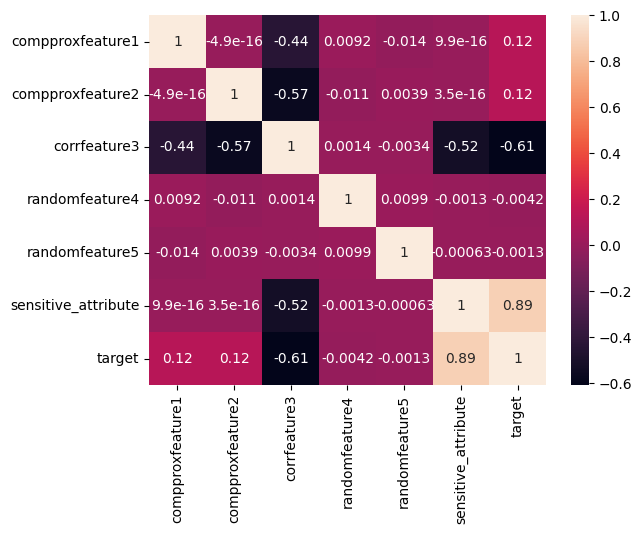

In [ ]:
if dataset==2:
  target_var = np.concatenate((np.zeros(5600), np.ones(4400)))
  sensattr = np.concatenate((np.zeros(5000), np.ones(5000)))
  feature1=np.concatenate((np.zeros(2500), np.ones(2500),np.zeros(2500), np.ones(2500)))
  feature2=np.concatenate((np.ones(2500), np.zeros(2500),np.zeros(2500),np.ones(2500)))
  feature5=np.random.randint(1,101,10000)
  feature4=np.random.randint(1000,20001,10000)
  feature3=np.concatenate((np.zeros(300),np.ones(7000),np.zeros(2700)))

  df = pd.DataFrame({'compproxfeature1':feature1, 'compproxfeature2':feature2, 'corrfeature3':feature3, 'randomfeature4':feature4, 'randomfeature5':feature5,
                     'sensitive_attribute':sensattr,
                     'target':target_var})
  corr_matrix = df.corr()
  sns.heatmap(corr_matrix, annot=True)
  plt.show()

# Dataset Folktables download & preparation


In [ ]:
if dataset == 1:
  %pip install folktables
  # load data manually from https://www2.census.gov/programs-surveys/acs/data/pums/2014/1-Year/ if not working
  # file name: csv_ptx
  from folktables import ACSDataSource, ACSIncome
  #from sklearn.preprocessing import StandardScaler

  # Step 1: Load the dataset
  data_source = ACSDataSource(survey_year='2014', horizon='1-Year', survey='person')
  ca_data = data_source.get_data(states=["TX"], download=True)  # Step 2: Extract features and target
  features, label, _ = ACSIncome.df_to_pandas(ca_data)

  # Step 3: Rename columns to match Adult dataset
  features = features.rename(columns={
      'AGEP': 'age',
      'COW': 'workclass',
      'SCHL': 'education',
      'MAR': 'marital-status',
      'OCCP': 'occupation',
      'RAC1P': 'race',
      'SEX': 'sex',
      'WKHP': 'hours-per-week'
  })
  f = features[['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex','age', 'hours-per-week']]



  # Add target variable
  f['income'] = label
  df=f
  df['sex']=df['sex'].astype(int)
  df.head()

<ipython-input-45-ddd2475ef30b>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f['income'] = label
<ipython-input-45-ddd2475ef30b>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sex']=df['sex'].astype(int)


In [ ]:
if dataset==1:
  marital_status_map = {
      1:"Married ",
      2:"Widowed",
      3:"Divorced",
      4:"Separated",
      5:"Never Married or Under 15"
  }
  df['marital-status'] = df['marital-status'].replace(marital_status_map)


<ipython-input-46-d038a829648a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['marital-status'] = df['marital-status'].replace(marital_status_map)


# Adult dataset download and preparation

In [ ]:

# Load the dataset
if dataset == 0:
  url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
  column_names = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
      "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
      "hours-per-week", "native-country", "income"]

  df = pd.read_csv(url, header=None, names=column_names, na_values='?', skipinitialspace=True)
  print(df.shape)

(32561, 15)


In [ ]:
if dataset==0:
  marital_status_labels = {
      'Married-civ-spouse': 'Married (Civilian Spouse)',
      'Married-AF-spouse': 'Married (Armed Forces Spouse)',
      'Married-spouse-absent': 'Married (Spouse Absent)',
      'Widowed': 'Widowed',
      'Divorced': 'Divorced',
      'Separated': 'Separated',
      'Never-married': 'Never Married'
  }

  # Mapping for relationship
  relationship_labels = {
      'Husband': 'Husband',
      'Wife': 'Wife',
      'Own-child': 'Own Child',
      'Not-in-family': 'Not in Family',
      'Other-relative': 'Other Relative',
      'Unmarried': 'Unmarried'
  }

  # Apply the mappings
  df['marital-status'] = df['marital-status'].map(marital_status_labels)
  df['relationship'] = df['relationship'].map(relationship_labels)


# Data depiction and preprocessing

In [ ]:
# Drop rows with missing values
df.dropna(inplace=True)

################introduce random subsample for testing purposees
df=df.sample(n=10000, random_state=42)
#################

<ipython-input-47-3f26b041b438>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [ ]:
column_names = df.columns
print("Features:\n", column_names)

Features:
 Index(['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex',
       'age', 'hours-per-week', 'income'],
      dtype='object')


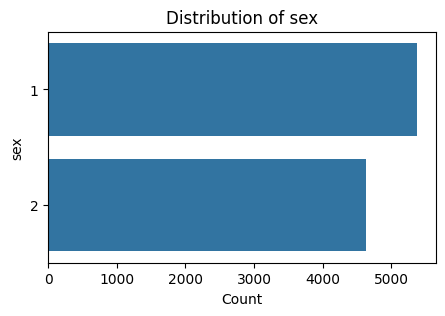

In [ ]:
plt.figure(figsize=(5, 3))
sns.countplot(y=sens_attr, data=df, order=df[sens_attr].value_counts().index)
plt.title(f'Distribution of {sens_attr}')
plt.xlabel('Count')
plt.ylabel(sens_attr)
plt.show()


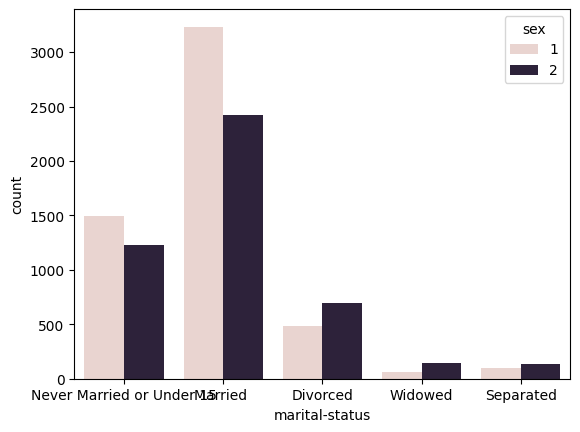

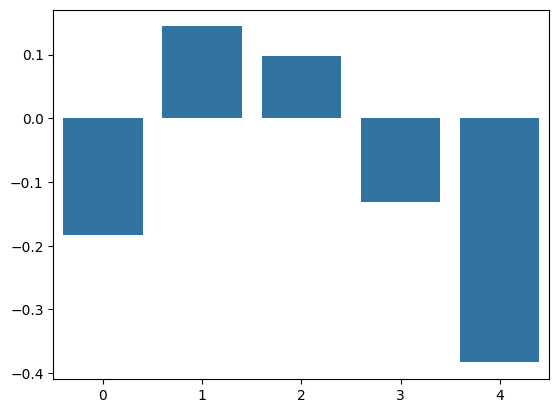

In [ ]:
if dataset==1:
  # dependecies of sex and occupation
  ct=pd.crosstab(df[sens_attr],df['occupation'])
  ct=np.array(ct)
  #print(ct.T)
  #sns.countplot(df, x='occupation', hue=sens_attr)
  #plt.show()
  #sns.barplot((ct[:,0]-ct[:,1])/(ct[:,0]+ct[:,1]))
  #plt.show()
  #dependencies between education and sex
  #ct=pd.crosstab(df[sens_attr],df['education'])
  #ct=np.array(ct)
  #print(ct.T)
  #sns.countplot(df, x='education', hue=sens_attr)
  #plt.show()
  #sns.barplot((ct.T[:,0]-ct.T[:,1])/(ct.T[:,0]+ct.T[:,1]))
  #plt.show()
  ct=pd.crosstab(df[sens_attr],df['marital-status'])
  ct=np.array(ct)
  #print(ct.T)
  sns.countplot(df, x='marital-status', hue=sens_attr)
  plt.show()
  sns.barplot((ct.T[:,0]-ct.T[:,1])/(ct.T[:,0]+ct.T[:,1]))
  plt.show()


In [ ]:
if dataset==0:
  # Crosstab between marital status and income
  marital_income = pd.crosstab(df['marital-status'], df['income'])
  print(marital_income,"\n")
  marital_sex = pd.crosstab(df['marital-status'], df['sex'])
  print(marital_sex)
  sumf = int(len(df['sex'])) - int(len(df['sex'][df['sex']=='Male']))
  # Plot the distribution of marital status by income
  plt.figure(figsize=(10, 6))
  sns.countplot(x='marital-status', hue='relationship', data=df)
  plt.xticks(rotation=45)
  plt.title('Marital Status Distribution by relationship')
  plt.show()

In [ ]:
ndf=df.copy()
if dataset != 2:
  # Convert categorical variables to numerical using Label Encoding
  categorical_columns = df.select_dtypes(include=['object']).columns
  label_encoders = {}

  for col in categorical_columns:
      le = LabelEncoder()
      ndf[col] = le.fit_transform(df[col])
      label_encoders[col] = le
      print(le.classes_)

  #make marital-stauts binary
  ndf.loc[((0 < ndf["marital-status"]) & (ndf["marital-status"]<= 3)), "marital-status"]=1
  ndf.loc[ndf["marital-status"] >3, "marital-status"]=0


#ordering relationship status approrpiately
if dataset==0:
  sns.countplot(ndf, x='relationship', hue='marital-status')
  plt.show()

  counts=np.zeros(6)
  for i in range(6):
    counts[i]=ndf["marital-status"][ndf["relationship"]==i].sum()
  print(counts)
  counts_ind = np.argsort(counts)
  print(counts_ind)
  for i in range(6):
    ndf.loc[ndf["relationship"]==counts_ind[i], ['relationship']]=i-6
  ndf['relationship']=ndf['relationship']+6

  sns.countplot(ndf, x='relationship', hue='marital-status')
  plt.show()
#Creating data splits from data frame
X=ndf.drop(target, axis=1)
y=ndf[target]
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the numerical features
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns


['Divorced' 'Married ' 'Never Married or Under 15' 'Separated' 'Widowed']


In [ ]:
# Stroing feature names of X_train for convenience
attributes= np.array(column_names)#_dummies_wo_income)
#['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex','age', 'hours-per-week','income']
attributes= np.array(column_names)#_dummies_wo_income)
attributes=attributes[attributes!=sens_attr]
attributes=attributes[attributes!=target]


In [ ]:
if dataset==0:
  # Plot distribution of marital status
  plt.figure(figsize=(5, 3))
  sns.countplot(y='marital-status', data=ndf, order=ndf['marital-status'].value_counts().index)
  plt.title('Distribution of Marital Status')
  plt.xlabel('Count')
  plt.yticks([0,1,2],['Married','Not Married',''])
  plt.ylabel('Marital Status')
  plt.show()

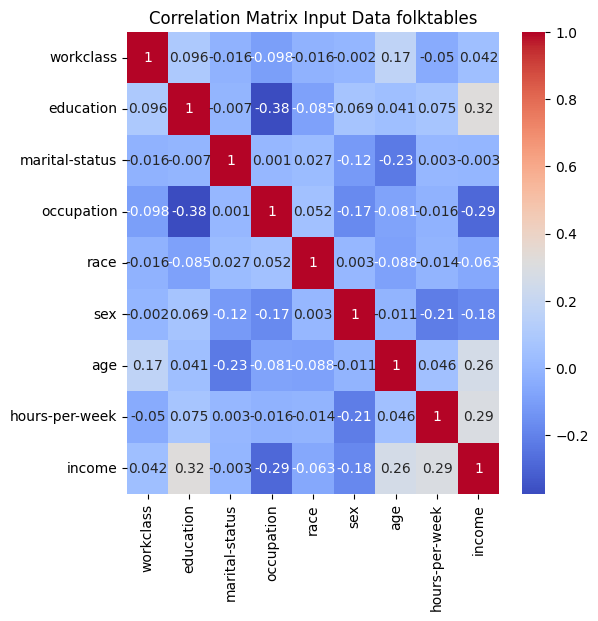

In [ ]:
# Correlation matrix
corr_matrix = round(ndf.corr(),3)
plt.figure(figsize=(6, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title(f'Correlation Matrix Input Data {name}')
plt.savefig(f'corr_matrix_{name}.png')
plt.show()

In [ ]:
if dataset==0:
  column_names = ndf.columns
  for a in column_names[0:-1]:
    b=np.corrcoef(X_train["marital-status"], X_train[a])[0,1]
    print(f" {a} has corrcoef: {b:.3f} ")

In [ ]:
# Normalize Data
scaler = StandardScaler()
protected_attribute_train = X_train[sens_attr]
protected_attribute_test = X_test[sens_attr]
X_train = X_train.drop(sens_attr, axis=1)
X_test = X_test.drop(sens_attr, axis=1)

numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Display the first few rows of the preprocessed DataFrame
#print(X_train.head())
#print(y_train.head())

# Functions for INLP and Encoder-Decoder Model

In [ ]:
###### Build Example encoder
#### Train the model
def train_model(X, y, epochs=50, batch_size=64, val_split=0.1, latent_space=8):
# Define the neural network model
    model = Sequential([
        Dense(latent_space*8, activation='relu', input_shape=(X.shape[1],)),  # Input layer
        Dropout(0.2),  # Dropout for regularization
        Dense(latent_space*4, activation='relu'),  # Hidden layer
        Dropout(0.2),
        Dense(latent_space*2, activation='relu'),
        Dropout(0.2),
        Dense(latent_space, activation='relu'),
        Dense(1, activation='sigmoid')  # Output layer (binary classification)
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    tf.random.set_seed(42)
    history = model.fit(
        X, y,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=val_split,
        verbose=1,
    )
    # Plot training history
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()
    return model

def get_encoder(input, last_layer):
      return Model(inputs=input, outputs=last_layer)

#### Evaluate model
def evaluate_model(model, X, y):
    # Evaluate the model on the test set
    y_pred_prob = model.predict(X)
    y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

    # Calculate accuracy and print classification report
    accuracy = accuracy_score(y, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y, y_pred))



In [ ]:

def define_decoder(X):
    # Define the decoder
    # Get the encoded features for the training and test sets
    encoded_X_train = X.copy()
    # Define the decoder
    input=encoded_X_train.shape[1]
    decoder_input = Input(shape=(input,))  # Input shape matches encoded features
    decoder_layer1 = Dense(input*2, activation='relu')(decoder_input)  # Output shape matches original features
    decoder_dropout1 = Dropout(0.2)(decoder_layer1)
    decoder_layer2 = Dense(input*4, activation='relu')(decoder_dropout1)
    decoder_dropout2 = Dropout(0.2)(decoder_layer2)
    decoder_layer3 = Dense(input*8, activation='relu')(decoder_dropout2)
    #decoder_dropout2 = Dropout(0.3)(decoder_layer3)
    #decoder_layer4 = Dense(128, activation='relu')(decoder_dropout2)
    decoder_output = Dense(X_train.shape[1], activation='linear')(decoder_layer3)  # Reconstruct original features

    # Decoder model
    decoder = Model(decoder_input, decoder_output)

    # Compile the decoder
    decoder.compile(optimizer='adam', loss='mse')  # Mean Squared Error for reconstruction

    # Summary of the decoder
    decoder.summary()
    return decoder

In [ ]:
# an abstract class for linear classifiers

class Classifier(object):

    def __init__(self):

        pass

    def train(self, X_train: np.ndarray, Y_train: np.ndarray, X_dev: np.ndarray, Y_dev: np.ndarray) -> float:
        """

        :param X_train:
        :param Y_train:
        :param X_dev:
        :param Y_dev:
        :return: accuracy score on the dev set
        """
        raise NotImplementedError

    def get_weights(self) -> np.ndarray:
        """
        :return: final weights of the model, as np array
        """

        raise NotImplementedError




class SKlearnClassifier(Classifier):

    def __init__(self, m):

        self.model = m

    def train_network(self, X_train: np.ndarray, Y_train: np.ndarray, X_dev: np.ndarray, Y_dev: np.ndarray) -> float:

        """
        :param X_train:
        :param Y_train:
        :param X_dev:
        :param Y_dev:
        :return: accuracy score on the dev set / Person's R in the case of regression
        """

        self.model.fit(X_train, Y_train)
        score = self.model.score(X_dev, Y_dev)
        return score

    def get_weights(self) -> np.ndarray:
        """
        :return: final weights of the model, as np array
        """

        w = self.model.coef_
        if len(w.shape) == 1:
                w = np.expand_dims(w, 0)

        return w

In [ ]:

from typing import Dict
import numpy as np
import scipy
from typing import List
from tqdm import tqdm
import random
import warnings


def get_rowspace_projection(W: np.ndarray) -> np.ndarray:
    """
    :param W: the matrix over its nullspace to project
    :return: the projection matrix over the rowspace
    """

    if np.allclose(W, 0):
        w_basis = np.zeros_like(W.T)
    else:
        w_basis = scipy.linalg.orth(W.T) # orthogonal basis

    P_W = w_basis.dot(w_basis.T) # orthogonal projection on W's rowspace

    return P_W

def get_projection_to_intersection_of_nullspaces(rowspace_projection_matrices: List[np.ndarray], input_dim: int):
    """
    Given a list of rowspace projection matrices P_R(w_1), ..., P_R(w_n),
    this function calculates the projection to the intersection of all nullspasces of the matrices w_1, ..., w_n.
    uses the intersection-projection formula of Ben-Israel 2013 http://benisrael.net/BEN-ISRAEL-NOV-30-13.pdf:
    N(w1)∩ N(w2) ∩ ... ∩ N(wn) = N(P_R(w1) + P_R(w2) + ... + P_R(wn))
    :param rowspace_projection_matrices: List[np.array], a list of rowspace projections
    :param dim: input dim
    """

    I = np.eye(input_dim)
    Q = np.sum(rowspace_projection_matrices, axis = 0)
    P = I - get_rowspace_projection(Q)

    return P

def debias_by_specific_directions(directions: List[np.ndarray], input_dim: int):
    """
    the goal of this function is to perform INLP on a set of user-provided directions (instead of learning those directions).
    :param directions: list of vectors, as numpy arrays.
    :param input_dim: dimensionality of the vectors.
    """

    rowspace_projections = []

    for v in directions:
        P_v = get_rowspace_projection(v)
        rowspace_projections.append(P_v)

    P = get_projection_to_intersection_of_nullspaces(rowspace_projections, input_dim)

    return P


def get_debiasing_projection(classifier_class, cls_params: Dict, num_classifiers: int, input_dim: int,
                             is_autoregressive: bool,
                             min_accuracy: float, X_train: np.ndarray, Y_train: np.ndarray, X_dev: np.ndarray,
                             Y_dev: np.ndarray, by_class=False, Y_train_main=None,
                             Y_dev_main=None, dropout_rate = 0) -> np.ndarray:
    """
    :param classifier_class: the sklearn classifier class (SVM/Perceptron etc.)
    :param cls_params: a dictionary, containing the params for the sklearn classifier
    :param num_classifiers: number of iterations (equivalent to number of dimensions to remove)
    :param input_dim: size of input vectors
    :param is_autoregressive: whether to train the ith classiifer on the data projected to the nullsapces of w1,...,wi-1
    :param min_accuracy: above this threshold, ignore the learned classifier
    :param X_train: ndarray, training vectors
    :param Y_train: ndarray, training labels (protected attributes)
    :param X_dev: ndarray, eval vectors
    :param Y_dev: ndarray, eval labels (protected attributes)
    :param by_class: if true, at each iteration sample one main-task label, and extract the protected attribute only from vectors from this class
    :param T_train_main: ndarray, main-task train labels
    :param Y_dev_main: ndarray, main-task eval labels
    :param dropout_rate: float, default: 0 (note: not recommended to be used with autoregressive=True)
    :return: P, the debiasing projection; rowspace_projections, the list of all rowspace projection; Ws, the list of all classifiers.
    """
    if dropout_rate > 0 and is_autoregressive:
        warnings.warn("Note: when using dropout with autoregressive training, the property w_i.dot(w_(i+1)) = 0 no longer holds.")

    I = np.eye(input_dim)

    if by_class:
        if ((Y_train_main is None) or (Y_dev_main is None)):
            raise Exception("Need main-task labels for by-class training.")
        main_task_labels = list(set(Y_train_main.tolist()))

    X_train_cp = X_train.copy()
    X_dev_cp = X_dev.copy()
    rowspace_projections = []
    Ws = []

    pbar = tqdm(range(num_classifiers))
    for i in pbar:

        clf = SKlearnClassifier(classifier_class(**cls_params))
        dropout_scale = 1./(1 - dropout_rate + 1e-6)
        dropout_mask = (np.random.rand(*X_train.shape) < (1-dropout_rate)).astype(float) * dropout_scale


        if by_class:
            #cls = np.random.choice(Y_train_main)  # uncomment for frequency-based sampling
            cls = random.choice(main_task_labels)
            relevant_idx_train = Y_train_main == cls
            relevant_idx_dev = Y_dev_main == cls
        else:
            relevant_idx_train = np.ones(X_train_cp.shape[0], dtype=bool)
            relevant_idx_dev = np.ones(X_dev_cp.shape[0], dtype=bool)

        acc = clf.train_network((X_train_cp * dropout_mask)[relevant_idx_train], Y_train[relevant_idx_train], X_dev_cp[relevant_idx_dev], Y_dev[relevant_idx_dev])
        pbar.set_description("iteration: {}, accuracy: {}".format(i, acc))
        print(acc)
        if acc < min_accuracy: continue

        W = clf.get_weights()
        Ws.append(W)
        P_rowspace_wi = get_rowspace_projection(W) # projection to W's rowspace
        rowspace_projections.append(P_rowspace_wi)

        if is_autoregressive:

            """
            to ensure numerical stability, explicitly project to the intersection of the nullspaces found so far (instaed of doing X = P_iX,
            which is problematic when w_i is not exactly orthogonal to w_i-1,...,w1, due to e.g inexact argmin calculation).
            """
            # use the intersection-projection formula of Ben-Israel 2013 http://benisrael.net/BEN-ISRAEL-NOV-30-13.pdf:
            # N(w1)∩ N(w2) ∩ ... ∩ N(wn) = N(P_R(w1) + P_R(w2) + ... + P_R(wn))

            P = get_projection_to_intersection_of_nullspaces(rowspace_projections, input_dim)
            # project

            X_train_cp = (P.dot(X_train.T)).T
            X_dev_cp = (P.dot(X_dev.T)).T

    """
    calculate final projection matrix P=PnPn-1....P2P1
    since w_i.dot(w_i-1) = 0, P2P1 = I - P1 - P2 (proof in the paper); this is more stable.
    by induction, PnPn-1....P2P1 = I - (P1+..+PN). We will use instead Ben-Israel's formula to increase stability and also generalize to the non-orthogonal case (e.g. with dropout),
    i.e., we explicitly project to intersection of all nullspaces (this is not critical at this point; I-(P1+...+PN) is roughly as accurate as this provided no dropout & regularization)
    """

    P = get_projection_to_intersection_of_nullspaces(rowspace_projections, input_dim)

    return P, rowspace_projections, Ws


In [ ]:
# Train the decoder
def train_decoder(X, projected_outputs, epochs=50, batch_size=64, val_split=0.2):
    decoder=define_decoder(projected_outputs)
    decoder.compile(optimizer='adam', loss='mse')
    # Train the decoder
    history_decoder_inlp = decoder.fit(
        projected_outputs, X,  # Train to reconstruct original features from encoded features
        epochs=epochs,
        batch_size=batch_size,
        validation_split=val_split,
        verbose=1
    )

    plt.plot(range(1,epochs+1),history_decoder_inlp.history['loss'], label='Training Loss')
    plt.plot(range(1,epochs+1),history_decoder_inlp.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    #plt.title('Decoder Training and Validation Loss')
    plt.legend()
    plt.show()
    return decoder

In [ ]:

def train_classifier(X, Z):
    """
    Train a classifier to predict the protected attributes Z from the data X.

    Args:
        X: Input data of shape (num_samples, num_features).
          -> here use the encoded features
        Z: Protected attributes of shape (num_samples, num_protected_attributes).

    Returns:
        W: The weight matrix of the trained classifier.
    """
    # Use logistic regression as the classifier
    classifier = LogisticRegression()
    classifier.fit(X,Z)
    print('accuracy of logistic classifier:', classifier.score(X,Z))
    # Return the weight matrix (coefficients) of the classifier
    return classifier.coef_.T  # Shape: (num_features, num_protected_attributes)

def iterative_nullspace_projection(X, Y, n_rounds=10):
    from sklearn.linear_model import SGDClassifier, Perceptron, LogisticRegression

    #N = 10000
    d = X.shape[1]

    num_classifiers = n_rounds
    classifier_class = LogisticRegression
    input_dim = d
    is_autoregressive = True
    min_accuracy = 0.0

    P, rowspace_projections, Ws = get_debiasing_projection(classifier_class, {}, num_classifiers, input_dim, is_autoregressive, min_accuracy, X, Y, X, Y, by_class = False)

    I = np.eye(P.shape[0])
    P_alternative = I - np.sum(rowspace_projections, axis = 0)
    P_by_product = I.copy()

    for P_Rwi in rowspace_projections:

        P_Nwi = I - P_Rwi
        P_by_product = P_Nwi.dot(P_by_product)


    #testing

    # validate that P = PnPn-1...P2P1 (should be true only when w_i.dot(w_(i+1)) = 0, in autoregressive training)

    if is_autoregressive:
        assert np.allclose(P_alternative, P)
        assert np.allclose(P_by_product, P)

    # validate that P is a projection

    assert np.allclose(P.dot(P), P)

    # validate that P projects to N(w1)∩ N(w2) ∩ ... ∩ N(wn)

    x = np.random.rand(d) - 0.5
    for w in Ws:

        assert np.allclose(np.linalg.norm(w.dot(P.dot(x))), 0.0)

    # validate that each two classifiers are orthogonal (this is expected to be true only with autoregressive training)

    if is_autoregressive:
        for i,w in enumerate(Ws):

            for j, w2 in enumerate(Ws):

                if i == j: continue

                assert np.allclose(np.linalg.norm(w.dot(w2.T)), 0)

    return P
'''
def iterative_nullspace_projection(X, Z, n_rounds=10):
    """
    Perform Iterative Nullspace Projection (INLP) to remove the influence of protected attributes Z from X.

    Args:
        X: Input data of shape (num_samples, num_features).
        Z: Protected attributes of shape (num_samples, num_protected_attributes).
        n_rounds: Number of iterations for INLP.
        batch_size: Batch size for processing large datasets.

    Returns:
        P: The final projection matrix of shape (num_features, num_features).
    """
    num_samples, num_features = X.shape
    P = np.eye(num_features)  # Initialize P as the identity matrix
    X_projected = X.T.copy()  # Initialize projected data

    for i in range(n_rounds):
        print(f"Iteration {i + 1}/{n_rounds}")
        # Train a classifier to predict Z from X_projected
        W = train_classifier(X_projected.T, Z).T
        # Compute the null space basis of W
        B = null_space(W)
        # Compute the projection matrix onto the null space of W
        PN = B @ B.T  # Shape: (num_features, num_features)
        # Update the overall projection matrix
        P = PN @ P
        # Update the projected data
        X_new = PN @ X_projected
                # Check stopping criteria
        if np.linalg.norm(X_projected - X_new) < 1e-2:
            print(f"Stopping early at iteration {i} due to small projection change.")
            break

        singular_values = np.linalg.svd(P, compute_uv=False)
        if np.min(singular_values) < 1e-8:
            print(f"Stopping early at iteration {i} due to low-rank collapse.")
            break

        X_projected=X_new
    return P
'''

def get_inlp(encoder_outputs, protected_attribute, n_rounds):
    # Perform INLP
    P = iterative_nullspace_projection(encoder_outputs, protected_attribute, n_rounds=n_rounds)
    return P

In [ ]:
# extract last layer
# store encoder ouputs
def get_encoder_output(model):
    # Create a new model that outputs the activations of the target layer
    return model.layers[-2].output
def get_encoder_input(model):
    return model.layers[0].input


# Test Pipeline INLP Enc-Dec Model

In [ ]:
########### Necessary Data input
only_inlp_change=False
if only_inlp_change ==  False:
  X_train= X_train
  y_train = y_train
  X_test= X_test
  y_test = y_test
  protected_attribute_test = protected_attribute_test
  protected_attribute_train = protected_attribute_train
###########


In [ ]:
############# Hyperparameter INLP
num_iterations = 5
latent_space= 8
#############

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,265 (12.75 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.6771 - loss: 0.5850 - val_accuracy: 0.7850 - val_loss: 0.4706
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7548 - loss: 0.4806 - val_accuracy: 0.7725 - val_loss: 0.4570
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7667 - loss: 0.4729 - val_accuracy: 0.7837 - val_loss: 0.4492
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7761 - loss: 0.4543 - val_accuracy: 0.7812 - val_loss: 0.4501
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7730 - loss: 0.4543 - val_accuracy: 0.7800 - val_loss: 0.4497
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7781 - loss: 0.4445 - val_accuracy: 0.7763 - val_loss: 0.4516
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7729 - loss: 0.4518 - val_accuracy: 0.7825 - val_loss: 0.4482
Epoch 8/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7832 - loss: 0.4456 - val_accuracy:

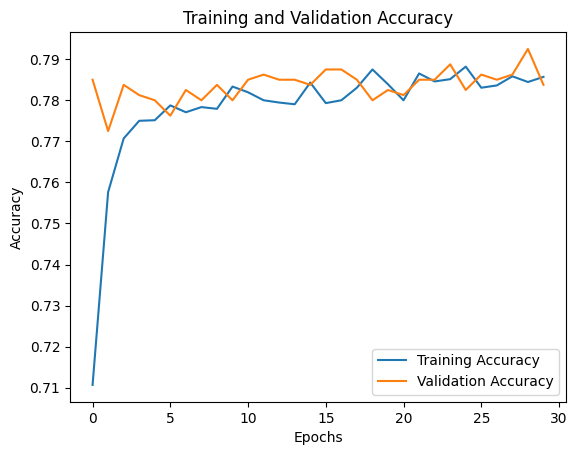

In [ ]:
### Train examined model
if only_inlp_change ==  False:
  model = train_model(X_train, y_train, epochs=30, batch_size=64, val_split=0.1, latent_space=latent_space)

In [ ]:
evaluate_model(model, X_test,y_test)

from sklearn.metrics import confusion_matrix
# Get model predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to binary predictions

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Print raw confusion matrix
print("Confusion Matrix:")
print(cm)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test Accuracy: 0.8010

Classification Report:
              precision    recall  f1-score   support

       False       0.84      0.88      0.86      1389
        True       0.70      0.61      0.65       611

    accuracy                           0.80      2000
   macro avg       0.77      0.75      0.76      2000
weighted avg       0.80      0.80      0.80      2000

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Confusion Matrix:
[[1229  160]
 [ 238  373]]


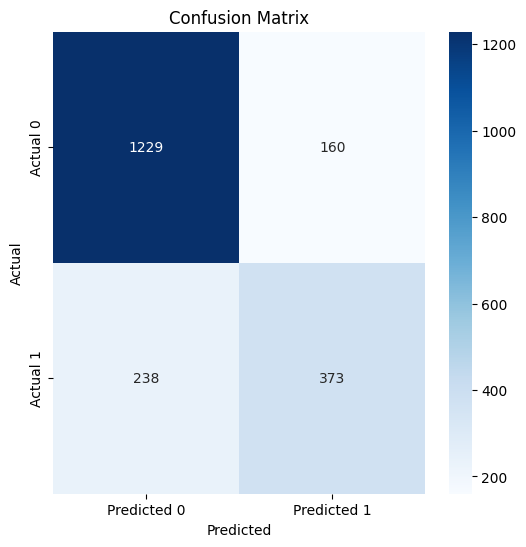

In [ ]:
# Visualize the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
### Trained parameters
encoded_data = get_encoder_output(model)
encoder = get_encoder(get_encoder_input(model), encoded_data)

# Check the shape of the encoded features
#print("Encoded X_train shape:", encoded_X_train.shape)
#print("Encoded X_test shape:", encoded_X_test.shape)


# Get the output of last layer as a NumPy array
encoder_outputs_train = encoder.predict(X_train)
encoder_outputs_test = encoder.predict(X_test)

# inlp projection of encoded data
inlp_matrix = get_inlp(encoder_outputs_train, protected_attribute_train, num_iterations)

# Project the data onto the null space
X_projected = (inlp_matrix @ encoder_outputs_test.T).T
X_projected_train = (inlp_matrix @ encoder_outputs_train.T).T

# Print results
print("Original Data Shape:", X.shape)
print("Projected Data Shape:", X_projected.shape)
print("Projection Matrix Shape:", inlp_matrix.shape)



250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


iteration: 4, accuracy: 0.55875: 100%|██████████| 5/5 [00:00<00:00, 44.44it/s]

0.620875
0.59725
0.587
0.56975
0.55875
Original Data Shape: (10000, 8)
Projected Data Shape: (2000, 8)
Projection Matrix Shape: (8, 8)


Testing model accuracy after cleaning the data with inlp:

In [ ]:
X_projected = (inlp_matrix @ encoder_outputs_test.T).T
X_projected_train = (inlp_matrix @ encoder_outputs_train.T).T

# Check accuracy of inp reconstruction for target
log=LogisticRegression()
log.fit(X_projected_train, y_train)
print('Accuracy of predicting y from inlp_projected X: ',log.score(X_projected, y_test))
print('majority vote result:', 1-y_test.sum()/len(y_test))

# Check if inlp reconstruction allows for predicting sens attr a
log=LogisticRegression()
log.fit(X_projected_train, protected_attribute_train)
print('Accuracy of predicting a from inlp_projected X: ', log.score(X_projected, protected_attribute_test))
print('majority vote result:', 1-protected_attribute_test.sum()/len(protected_attribute_test))

# Get the accuracy of the original datasets prediction for the sens attr
log=LogisticRegression()
log.fit(X_train, protected_attribute_train)
print('Accuracy of predicting a from X: ', log.score(X_test, protected_attribute_test))

Accuracy of predicting y from inlp_projected X:  0.7985
majority vote result: 0.6945
Accuracy of predicting a from inlp_projected X:  0.561
majority vote result: -0.45599999999999996
Accuracy of predicting a from X:  0.6025


How impactful are the features changed by the inlp matrix:

In [ ]:
print("The weights sorted by the differences introduced by the cleaning process + change strength:\n",
      np.round(np.stack((np.array(model.weights[-2].value)[np.argsort(-np.mean(X_projected - encoder_outputs_test,axis=0)**2)].flatten(),-np.sort(-np.mean(X_projected - encoder_outputs_test,axis=0)**2)),axis=1),3))

The weights sorted by the differences introduced by the cleaning process + change strength:
 [[-0.748  0.01 ]
 [ 0.538  0.009]
 [ 0.176  0.003]
 [-0.835  0.002]
 [ 0.209  0.002]
 [-0.251  0.001]
 [-0.591  0.001]
 [ 0.693  0.   ]]


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,255 (12.71 KB)

 Trainable params: 3,255 (12.71 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.0294 - val_loss: 0.8526
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8576 - val_loss: 0.8003
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8135 - val_loss: 0.7757
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7888 - val_loss: 0.7478
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7692 - val_loss: 0.7263
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7450 - val_loss: 0.7094
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7291 - val_loss: 0.6962
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7134 - val_loss: 0.6876
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7089 - val_loss: 0.6808
Epoch 10/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7036 - val_loss: 0.6744
Epoch 11/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6951 - val_loss: 0.6713
Epoch 12/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

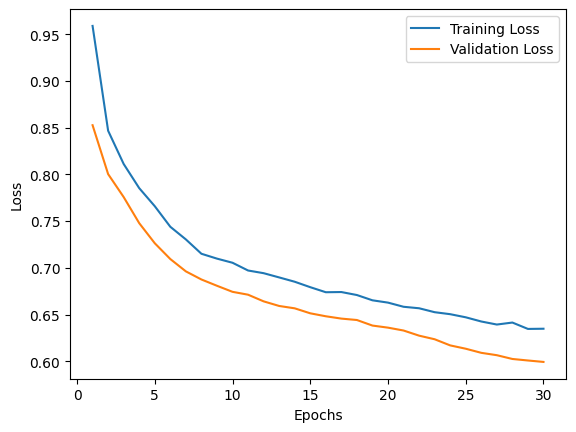

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,255 (12.71 KB)

 Trainable params: 3,255 (12.71 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,255 (12.71 KB)

 Trainable params: 3,255 (12.71 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.9622 - val_loss: 0.8256
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8326 - val_loss: 0.8205
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8203 - val_loss: 0.8161
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8157 - val_loss: 0.8138
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8104 - val_loss: 0.8128
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8075 - val_loss: 0.8081
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8033 - val_loss: 0.8071
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8006 - val_loss: 0.8039
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7986 - val_loss: 0.8006
Epoch 10/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7951 - val_loss: 0.7989
Epoch 11/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7926 - val_loss: 0.7918
Epoch 12/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

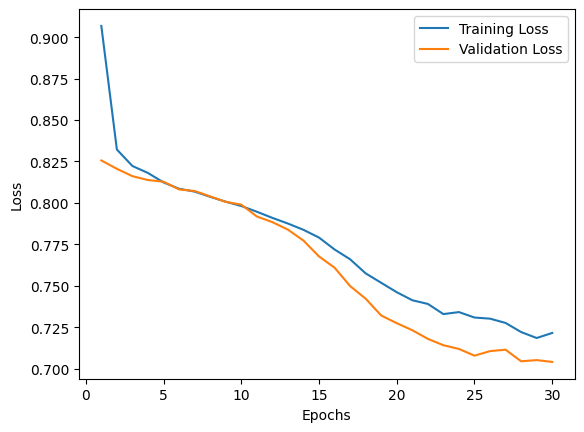

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
#### decoder
#decoder = define_decoder(encoder_outputs_train)
if False == only_inlp_change:
  decoder_trained = train_decoder(X_train, encoder_outputs_train, epochs=30)

# Reconstruct the test set

  reconstructed_X_test = decoder_trained.predict(encoder_outputs_test)



#### decoder with inlp

### retrain decoder
decoder2 = define_decoder(X_projected_train)
decoder_trained_inlp = train_decoder(X_train, X_projected_train, epochs=30)

# Reconstruct the test set
reconstructed_X_test_inlp = decoder_trained_inlp.predict(X_projected)
reconstructed_X_test_inlp_old = decoder_trained.predict(X_projected)



In [ ]:
#original data corrrelation to pa
b=np.zeros_like(attributes)
for (a, i) in zip(attributes, range(len(attributes))):
  b[i]=abs(np.corrcoef(protected_attribute_test, X_test[a])[0,1])
  print(f" {a} has corrcoef: {float(b[i]):.3f} with a in X_test")
arg=np.argmax(b)
b=np.nan_to_num(b,nan=0)
print(f"\n max correlation is {attributes[arg]}: {float(b[arg]):.3f}")

 workclass has corrcoef: 0.032 with a in X_test
 education has corrcoef: 0.066 with a in X_test
 marital-status has corrcoef: 0.108 with a in X_test
 occupation has corrcoef: 0.119 with a in X_test
 race has corrcoef: 0.004 with a in X_test
 age has corrcoef: 0.018 with a in X_test
 hours-per-week has corrcoef: 0.210 with a in X_test

 max correlation is hours-per-week: 0.210


In [ ]:
# normal reconstruction correlation to pa
b2=np.zeros_like(attributes, dtype='float')
for (a, i) in zip(attributes, range(len(attributes))):
  b2[i]=abs(np.corrcoef(protected_attribute_test, reconstructed_X_test[:,i])[0,1])
  print(f" {a} has corrcoef: {float(b2[i]):.3f} in X_test")
b2 = np.nan_to_num(b2,nan=0)
#print(b2)
arg=np.argmax(b2)
print(f"\n max correlation is {attributes[arg]}: {float(b2[arg]):.3f}")


 workclass has corrcoef: 0.008 in X_test
 education has corrcoef: 0.040 in X_test
 marital-status has corrcoef: 0.077 in X_test
 occupation has corrcoef: 0.032 in X_test
 race has corrcoef: 0.088 in X_test
 age has corrcoef: 0.000 in X_test
 hours-per-week has corrcoef: 0.223 in X_test

 max correlation is hours-per-week: 0.223


In [ ]:
#inlp (same decoder) reconstruction correlation to pa
b4=np.zeros_like(attributes, dtype='float')
for (a, i) in zip(attributes, range(len(attributes))):
  b4[i]=abs(np.corrcoef(protected_attribute_test, reconstructed_X_test_inlp_old[:,i])[0,1])
  print(f" {a} has corrcoef: {float(b4[i]):.3f} with a in X_test")
b4 = np.nan_to_num(b4,nan=0)
#print(b2)
arg=np.argmax(b4)
print(f"\n max correlation is {attributes[arg]}: {float(b4[arg]):.3f}")

 workclass has corrcoef: 0.006 with a in X_test
 education has corrcoef: 0.144 with a in X_test
 marital-status has corrcoef: 0.139 with a in X_test
 occupation has corrcoef: 0.128 with a in X_test
 race has corrcoef: 0.114 with a in X_test
 age has corrcoef: 0.150 with a in X_test
 hours-per-week has corrcoef: 0.069 with a in X_test

 max correlation is age: 0.150


In [ ]:
#inlp reconstruction correlation to pa
b3=np.zeros_like(attributes, dtype='float')
for (a, i) in zip(attributes, range(len(attributes))):
  b3[i]=abs(np.corrcoef(protected_attribute_test, reconstructed_X_test_inlp[:,i])[0,1])
  print(f" {a} has corrcoef: {float(b3[i]):.3f} with a in X_test")
b3 = np.nan_to_num(b3,nan=0)
#print(b2)
arg=np.argmax(b3)
print(f"\n max correlation is {attributes[arg]}: {float(b3[arg]):.3f}")

 workclass has corrcoef: 0.016 with a in X_test
 education has corrcoef: 0.134 with a in X_test
 marital-status has corrcoef: 0.080 with a in X_test
 occupation has corrcoef: 0.086 with a in X_test
 race has corrcoef: 0.075 with a in X_test
 age has corrcoef: 0.025 with a in X_test
 hours-per-week has corrcoef: 0.172 with a in X_test

 max correlation is hours-per-week: 0.172


In [ ]:
# Calculate reconstruction error (MRE), using same decoder
reconstruction_error = np.mean(np.square(X_test - reconstructed_X_test),axis=0)
print(f"\n Mean Reconstruction Error (MRE): {np.mean(reconstruction_error):.4f}")
print(f"\n TOP 3 Highest Reconstruction Error (MRE) of one attribute are: {np.sort(reconstruction_error)[-3:]} is {attributes[np.array(np.argsort(reconstruction_error)[-3:])]}")
# Calculate reconstruction error (MRE) of INLP
reconstruction_error_inlp = np.mean(np.square(X_test - reconstructed_X_test_inlp_old),axis=0)
print(f"\n Mean Reconstruction Error (MRE) w INLP: {np.mean(reconstruction_error_inlp):.4f}")
print(f"\n TOP 3 Highest Reconstruction Error (MRE) w INLP of one attriute are: {np.sort(reconstruction_error_inlp)[-3:]} is {attributes[np.array(np.argsort(reconstruction_error_inlp)[-3:])]}")
# diff:
#biggest difference in reconstruction
rec_diff= reconstruction_error_inlp-reconstruction_error
for a,b,c in zip(attributes,rec_diff, reconstruction_error):
  print(f'{a}:    reconstruction diff:{b:.3f}, Rec_error:{c:.3f}')
#print(attributes)
print(f"\n TOP 3 Highest Reconstruction Error (MRE) difference of one attriute are: {np.sort(rec_diff)[-3:]} is {attributes[np.array(np.argsort(rec_diff)[-3:])]}")


 Mean Reconstruction Error (MRE): 0.5740

 TOP 3 Highest Reconstruction Error (MRE) of one attribute are: [0.61521871 0.69411664 0.80774907] is ['workclass' 'marital-status' 'race']

 Mean Reconstruction Error (MRE) w INLP: 0.9502

 TOP 3 Highest Reconstruction Error (MRE) w INLP of one attriute are: [1.06907854 1.10021974 1.29300657] is ['age' 'workclass' 'marital-status']
workclass:    reconstruction diff:0.485, Rec_error:0.615
education:    reconstruction diff:0.212, Rec_error:0.565
marital-status:    reconstruction diff:0.599, Rec_error:0.694
occupation:    reconstruction diff:0.212, Rec_error:0.450
race:    reconstruction diff:0.111, Rec_error:0.808
age:    reconstruction diff:0.662, Rec_error:0.407
hours-per-week:    reconstruction diff:0.353, Rec_error:0.479

 TOP 3 Highest Reconstruction Error (MRE) difference of one attriute are: [0.48500102 0.59888993 0.66245644] is ['workclass' 'marital-status' 'age']


In [ ]:
# Calculate reconstruction error (MRE), newly trained decoder
reconstruction_error = np.mean(np.square(X_test - reconstructed_X_test),axis=0)
print(f"\n Mean Reconstruction Error (MRE): {np.mean(reconstruction_error):.4f}")
print(f"\n TOP 3 Highest Reconstruction Error (MRE) of one attribute are: {np.sort(reconstruction_error)[-3:]} is {attributes[np.array(np.argsort(reconstruction_error)[-3:])]}")
# Calculate reconstruction error (MRE) of INLP
reconstruction_error_inlp = np.mean(np.square(X_test - reconstructed_X_test_inlp),axis=0)
print(f"\n Mean Reconstruction Error (MRE) w INLP: {np.mean(reconstruction_error_inlp):.4f}")
print(f"\n TOP 3 Highest Reconstruction Error (MRE) w INLP of one attriute are: {np.sort(reconstruction_error_inlp)[-3:]} is {attributes[np.array(np.argsort(reconstruction_error_inlp)[-3:])]}")
# diff:
#biggest difference in reconstruction
rec_diff= reconstruction_error_inlp-reconstruction_error
for a,b,c in zip(attributes,rec_diff, reconstruction_error):
  print(f'{a}:    reconstruction diff:{b:.3f}, Rec_error:{c:.3f}')
#print(attributes)
print(f"\n TOP 3 Highest Reconstruction Error (MRE) difference of one attriute are: {np.sort(rec_diff)[-3:]} is {attributes[np.array(np.argsort(rec_diff)[-3:])]}")


 Mean Reconstruction Error (MRE): 0.5740

 TOP 3 Highest Reconstruction Error (MRE) of one attribute are: [0.61521871 0.69411664 0.80774907] is ['workclass' 'marital-status' 'race']

 Mean Reconstruction Error (MRE) w INLP: 0.6886

 TOP 3 Highest Reconstruction Error (MRE) w INLP of one attriute are: [0.71823175 0.8269473  0.85086689] is ['marital-status' 'workclass' 'race']
workclass:    reconstruction diff:0.212, Rec_error:0.615
education:    reconstruction diff:0.125, Rec_error:0.565
marital-status:    reconstruction diff:0.024, Rec_error:0.694
occupation:    reconstruction diff:0.159, Rec_error:0.450
race:    reconstruction diff:0.043, Rec_error:0.808
age:    reconstruction diff:0.114, Rec_error:0.407
hours-per-week:    reconstruction diff:0.126, Rec_error:0.479

 TOP 3 Highest Reconstruction Error (MRE) difference of one attriute are: [0.12557967 0.1585772  0.21172859] is ['hours-per-week' 'occupation' 'workclass']


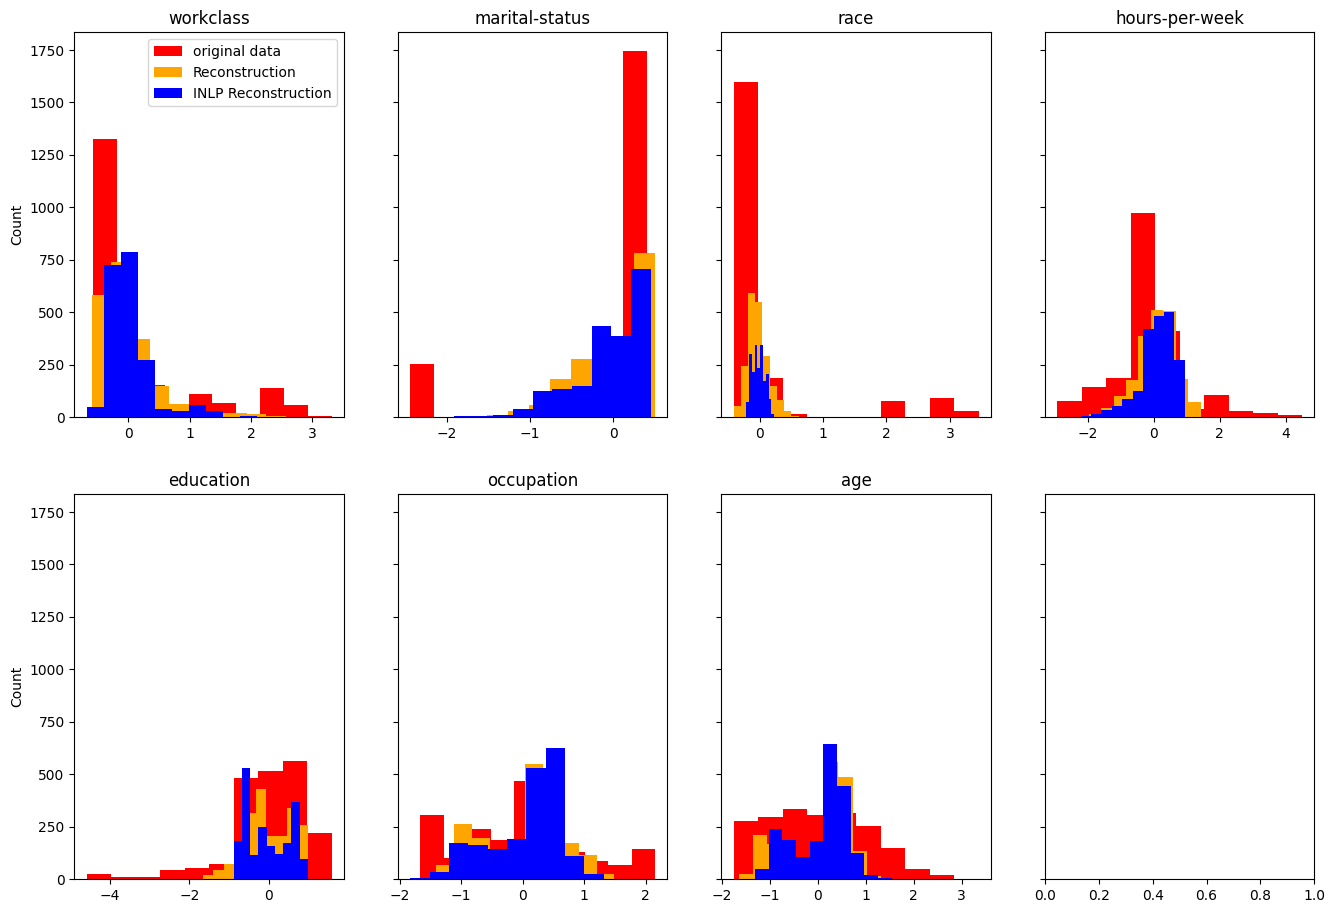

In [ ]:
# Compare reconstructions of features in distriution with original
t=2
fig,plot=plt.subplots(t,len(attributes)//t+1, figsize=(16, 11),sharex=False,sharey=True)
for s in range(len(attributes)):
  #plot(s//2,s%2).figure(figsize=(5,3))
  plot[s%t,s//t].hist(X_test[attributes[s]], color='red',label='original data')
  #plot[s//2,s%2].figure(figsize=(5,3)
  plot[s%t,s//t].hist(reconstructed_X_test[:,s],color='orange', label= 'Reconstruction')
  plot[s%t,s//t].hist(reconstructed_X_test_inlp[:,s],color='blue', label='INLP Reconstruction')
  plot[s%t,s//t].set_title(attributes[s])
  if s==0:
    plot[s//t,s%t].legend()
  if s%t==2:
    plot[s%t,s//t].set_xlabel('Value')
  if s//t==0:
    plot[s%t,s//t].set_ylabel('Count')
plt.savefig(f'reconstruction_comparison_{name}.png')
plt.show()

['marital-status' 'race' 'age' 'education' 'hours-per-week']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_39 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6206 - loss: 0.6519 - val_accuracy: 0.7788 - val_loss: 0.4806
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7650 - loss: 0.4929 - val_accuracy: 0.7850 - val_loss: 0.4543
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7710 - loss: 0.4793 - val_accuracy: 0.7812 - val_loss: 0.4494
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7773 - loss: 0.4737 - val_accuracy: 0.7775 - val_loss: 0.4482
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7755 - loss: 0.4680 - val_accuracy: 0.7819 - val_loss: 0.4469
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7775 - loss: 0.4634 - val_accuracy: 0.7800 - val_loss: 0.4460
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7843 - loss: 0.4576 - val_accuracy: 0.7788 - val_loss: 0.4466
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7830 - loss: 0.4547 - val_accuracy: 0.

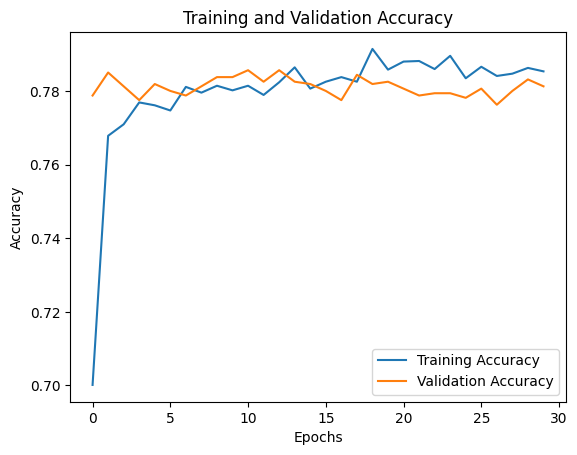

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test Accuracy: 0.8020

Classification Report:
              precision    recall  f1-score   support

       False       0.84      0.88      0.86      1389
        True       0.70      0.62      0.66       611

    accuracy                           0.80      2000
   macro avg       0.77      0.75      0.76      2000
weighted avg       0.80      0.80      0.80      2000



'\nelse:\n  X_rem=X_train[np.argsort(rec_diff)[:-2]]\n  X_test_rem=X_test[np.argsort(rec_diff)[:-2]]\n  model_test = train_model(X_rem, y_train, epochs=30, batch_size=64, val_split=0.2, latent_space=latent_space)\n  evaluate_model(model_test, X_test_rem,y_test)\n'

In [ ]:
print(attributes[np.argsort(rec_diff)[:-2]])
X_rem=X_train[attributes[np.argsort(rec_diff)[:-1]]]
X_test_rem=X_test[attributes[np.argsort(np.array(rec_diff))][:-1]]
model_test = train_model(X_rem, y_train, epochs=30, batch_size=64, val_split=0.2, latent_space=latent_space)
evaluate_model(model_test, X_test_rem,y_test)
"""
else:
  X_rem=X_train[np.argsort(rec_diff)[:-2]]
  X_test_rem=X_test[np.argsort(rec_diff)[:-2]]
  model_test = train_model(X_rem, y_train, epochs=30, batch_size=64, val_split=0.2, latent_space=latent_space)
  evaluate_model(model_test, X_test_rem,y_test)
"""

In [ ]:
encoded_data_rem = get_encoder_output(model_test)
encoder = get_encoder(get_encoder_input(model_test), encoded_data_rem)
encoder_outputs_rem= encoder.predict(X_rem)
encoder_outputs_rem_test= encoder.predict(X_test_rem)

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
print(f"Accuracy of predicting a from X: {log.score(X_test, protected_attribute_test)}")
#Check if the protected attribute is predicatble from reconstructed data
reconstructed_X_train = decoder_trained.predict(encoder_outputs_train)
linearmodel2 = LogisticRegression()
linearmodel2.fit(reconstructed_X_train, protected_attribute_train)
print(f"Accuracy of predicting a from X_reconstructed: {linearmodel2.score(reconstructed_X_test, protected_attribute_test)}")

#Check if the protected attribute is predicatble from reconstructed data with INLP
reconstructed_X_train_inlp = decoder_trained.predict(X_projected_train)
linearmodel3 = LogisticRegression()
linearmodel3.fit(reconstructed_X_train_inlp, protected_attribute_train)
print(f"Accuracy of predicting a from X_reconstructed_INLP: {linearmodel3.score(reconstructed_X_test_inlp, protected_attribute_test)}")

#Check if the protected attribute is predicatble from reconstructed data
reconstructed_X_train = decoder_trained.predict(encoder_outputs_rem)
reconstructed_X_test = decoder_trained.predict(encoder_outputs_rem_test)
linearmodel2 = LogisticRegression()
linearmodel2.fit(reconstructed_X_train, protected_attribute_train)
print(f"Accuracy of predicting a from X_reconstructed without having relationship in training: {linearmodel2.score(reconstructed_X_test, protected_attribute_test)}")


#Majority vote ratio
print("Majority vote result:", abs((protected_attribute_test.sum()-len(protected_attribute_test))/len(protected_attribute_test)))

Accuracy of predicting a from X: 0.6025
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy of predicting a from X_reconstructed: 0.6165
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy of predicting a from X_reconstructed_INLP: 0.525
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy of predicting a from X_reconstructed without having relationship in training: 0.6105
Majority vote result: 0.456


# Data modification as identification tool

In [ ]:
def train_model_Pope(X_with_a, X, a, output_space, orgmodel, epochs=20, batch_size=64, val_split=0.2, lc=0.5, lr=0.2):

    class CustomLoss(tf.keras.losses.Loss):
        def __init__(self, lr, lc, a, orgmodel, **kwargs):
            super().__init__(**kwargs)
            self.lr = lr
            self.lc = lc
            self.orgmodel= orgmodel
            self.a = tf.cast(a, tf.float32)

        def call(self, y_true, y_pred):
            # Reconstruction loss (MSE)
            # y_true is the original input for the batch
            @tf.function(input_signature=[tf.TensorSpec(shape=y_pred.shape, dtype=y_pred.dtype)])
            def predict_ys(y_pred):
                return self.orgmodel(y_pred)

            ys = predict_ys(y_true)
            ys_pred = predict_ys(y_pred)
            recon_loss = tf.reduce_mean(tf.square(y_pred - y_true))

            # Independence measure via correlation (approximation)
            corr = tf.reduce_mean(((ys_pred - tf.reduce_mean(ys_pred))/tf.math.reduce_std(ys_pred)) *
                                 ((self.a - tf.reduce_mean(self.a))/tf.math.reduce_std(self.a)))
            independence_loss = tf.square(corr)
            acc_loss = tf.reduce_mean(tf.square(ys_pred - ys))
            return acc_loss + self.lr * recon_loss + self.lc * independence_loss

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(output_space*4, activation='relu', input_shape=(X_with_a.shape[1],)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(output_space*2, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(output_space, activation='sigmoid'),
    ])

    model.compile(
        optimizer='adam',
        loss=CustomLoss(lr=lr, lc=lc, a=a, orgmodel=orgmodel),
        metrics=['accuracy']
    )

    history = model.fit(
        X_with_a, X,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=val_split,
        verbose=1,
    )

  # Plot training history (optional)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()
    return model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,137 (12.25 KB)

 Trainable params: 3,137 (12.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6194 - loss: 0.6163 - val_accuracy: 0.9200 - val_loss: 0.2334
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9172 - loss: 0.2173 - val_accuracy: 0.9400 - val_loss: 0.1422
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9400 - loss: 0.1441 - val_accuracy: 0.9400 - val_loss: 0.1407
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9424 - loss: 0.1340 - val_accuracy: 0.9400 - val_loss: 0.1402
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9419 - loss: 0.1305 - val_accuracy: 0.9400 - val_loss: 0.1399
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9426 - loss: 0.1310 - val_accuracy: 0.9400 - val_loss: 0.1400
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9426 - loss: 0.1299 - val_accuracy: 0.9400 - val_loss: 0.1400
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9421 - loss: 0.1292 - val_accuracy: 0

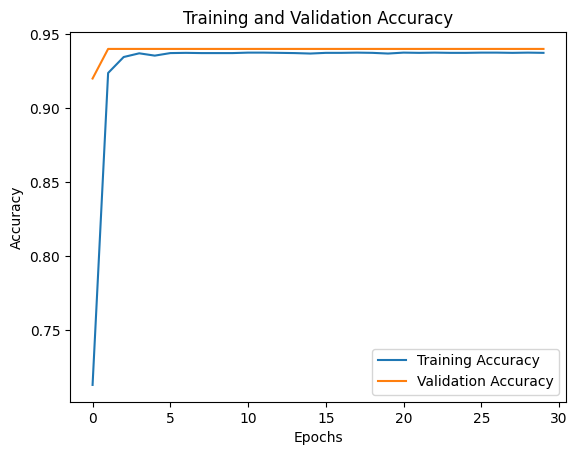

In [ ]:
latent_space=8
orgmodel = train_model(X_train, y_train, epochs=30, batch_size=64, val_split=0.2, latent_space=latent_space)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.3828 - loss: 0.6225 - val_accuracy: 0.4925 - val_loss: 0.6018
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4368 - loss: 0.5749 - val_accuracy: 0.4875 - val_loss: 0.5521
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4978 - loss: 0.5187 - val_accuracy: 0.5775 - val_loss: 0.2614
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5215 - loss: 0.2827 - val_accuracy: 0.5975 - val_loss: 0.2439
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5229 - loss: 0.2597 - val_accuracy: 0.5456 - val_loss: 0.2403
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5171 - loss: 0.2510 - val_accuracy: 0.5550 - val_loss: 0.2382
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5275 - loss: 0.2449 - val_accuracy: 0.5512 - val_loss: 0.2353
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5114 - loss: 0.2412 - val_accuracy: 0

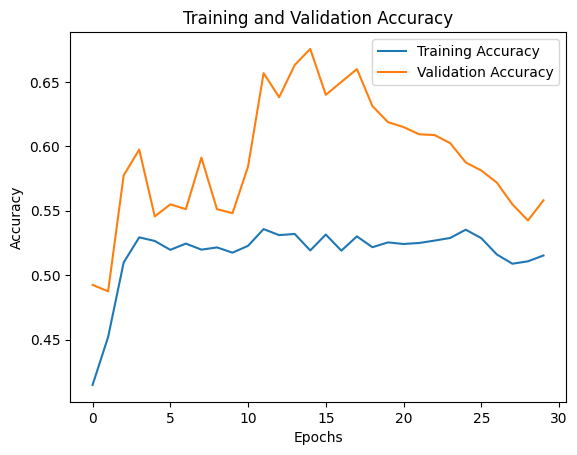

In [ ]:
input_shape= get_encoder_input(orgmodel).shape[1]
a=np.array(protected_attribute_train)
X_with_a= np.concatenate((X_train,a.reshape(-1,1)),axis=1)
datamodel= train_model_Pope(X_with_a, X_train, a, input_shape, orgmodel, epochs=30)

In [ ]:
a_test=np.array(protected_attribute_test)
test_pred=datamodel.predict(np.concatenate((X_test,a_test.reshape(-1,1)),axis=1))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
for x in range(len(attributes)):
  print( f"{attributes[np.argsort(-np.mean(np.square(test_pred-X_test),axis=0))][x]} differs from original by {-np.sort(-np.mean(np.square(test_pred-X_test),axis=0))[x]:.3f}")


randomfeature5 differs from original by 0.818
randomfeature4 differs from original by 0.806
corrfeature3 differs from original by 0.802
compproxfeature1 differs from original by 0.747
compproxfeature2 differs from original by 0.745


#Anomaly Detection


In [ ]:
#data preparation:
X = ndf.drop(columns=[target])
y = ndf[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
scaler=StandardScaler()
latent_space=6

#Store sensitive attribute and remove it from data set
y2 = X_train[sens_attr]
X_train=X_train.drop(columns=[sens_attr])
y2_test = X_test[sens_attr]
X_test=X_test.drop(columns=[sens_attr])

if np.sum(y2==0) > np.sum(y2==1):
  y2.loc[y2==1]=2
  y2.loc[y2==0]=1
  y2_test.loc[y2_test==1]=2
  y2_test.loc[y2_test==0]=1
else:
  y2.loc[y2==1]=1
  y2.loc[y2==0]=2
  y2_test.loc[y2_test==1]=1
  y2_test.loc[y2_test==0]=2

# Normalize data
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 48)             │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 24)             │         1,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 12)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,233 (8.72 KB)

 Trainable params: 2,233 (8.72 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.7362 - loss: 0.5651 - val_accuracy: 0.7550 - val_loss: 0.4181
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7367 - loss: 0.4644 - val_accuracy: 0.7921 - val_loss: 0.3923
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7674 - loss: 0.4330 - val_accuracy: 0.8400 - val_loss: 0.3786
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7969 - loss: 0.4266 - val_accuracy: 0.8487 - val_loss: 0.3707
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8031 - loss: 0.4188 - val_accuracy: 0.8471 - val_loss: 0.3605
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8160 - loss: 0.3992 - val_accuracy: 0.8487 - val_loss: 0.3534
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8243 - loss: 0.3962 - val_accuracy: 0.8500 - val_loss: 0.3465
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8296 - loss: 0.3834 - val_accuracy: 0.8500 - val_loss

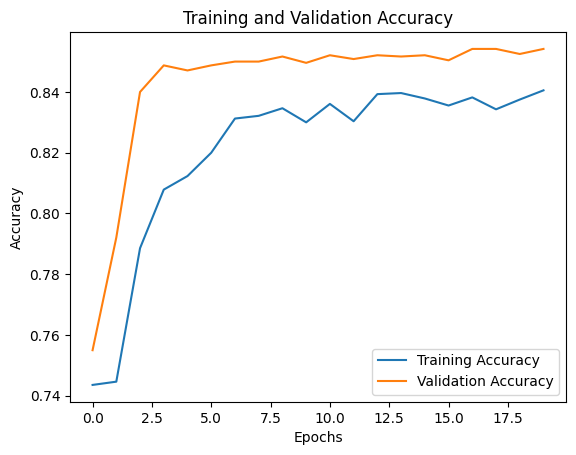

In [ ]:
#encoder_model:
ad_model = train_model(X_train, y_train, epochs=20, batch_size=64, val_split=0.3, latent_space=latent_space)


In [ ]:
ad_encoded_data = get_encoder_output(ad_model)
ad_encoder = get_encoder(get_encoder_input(ad_model), ad_encoded_data)


# Get the outputof last layer as a NumPy array
encoded_X_train = ad_encoder.predict(X_train)
encoded_X_test = ad_encoder.predict(X_test)

#split ecoded data in normal and anomal data
normals_train = encoded_X_train[y2==1]
anomalies_train = encoded_X_train[y2==2]

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [ ]:
def orthogonal_projection_constraint(W_e, W_d, X):
    """ Compute the orthogonality constraint loss """
    X_T = tf.transpose(X)
    P_H1 = tf.matmul(X_T,tf.linalg.pinv(X_T))  # Projection operator
    P_approx = tf.matmul(W_e, W_d, transpose_a=True, transpose_b=True)  # Approximate projection operator
    return tf.norm(P_approx - P_H1)**2

class Autoencoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Dense(latent_dim, use_bias=False)
        self.decoder = Dense(input_dim, use_bias=False)

    def call(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, z

def train_step(X_train, enc_X_train, decmodel):
    with tf.GradientTape() as tape:
        enc_X_reconstructed, Z = autoencoder(enc_X_train)
        pred_X = decmodel(enc_X_reconstructed)
        # Compute loss terms
        projection_loss = loss_fn(enc_X_train, enc_X_reconstructed)
        reconstruction_loss = loss_fn(X_train, pred_X)
        opc_loss = orthogonal_projection_constraint(autoencoder.encoder.weights[0],
                                                   autoencoder.decoder.weights[0], enc_X_train)

        loss = reconstruction_loss + lambda1 * projection_loss + lambda2 * opc_loss

    gradients = tape.gradient(loss, autoencoder.trainable_variables)
    optimizer.apply_gradients(zip(gradients, autoencoder.trainable_variables))
    return projection_loss,opc_loss,loss

In [ ]:
# Hyperparameters
input_dim = encoded_X_train.shape[-1]  # Example input dimension
latent_dim = latent_space  # Latent space dimension
learning_rate = 0.01
lambda1 = 0.1
lambda2 = 0.4

# Initialize model, loss, optimizer
autoencoder = Autoencoder(input_dim, latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate)
loss_fn = tf.keras.losses.MeanSquaredError()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 12)             │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 24)             │           312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 48)             │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 13)             │           637 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,233 (8.72 KB)

 Trainable params: 2,233 (8.72 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 1.0984 - val_loss: 0.9542
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9690 - val_loss: 0.9028
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9163 - val_loss: 0.8529
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8772 - val_loss: 0.8195
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8493 - val_loss: 0.7982
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8243 - val_loss: 0.7818
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8174 - val_loss: 0.7696
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8041 - val_loss: 0.7593
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7939 - val_loss: 0.7519
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7928 - val_loss: 0.7471
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7762 - val_loss: 0.7458
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7789 - val_l

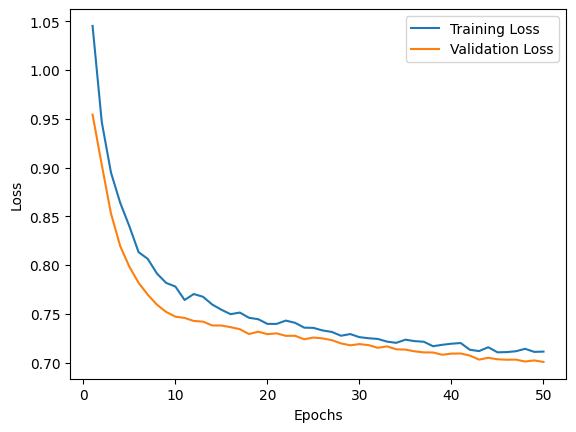

In [ ]:
decmodel = train_decoder(X_train, encoded_X_train, epochs=50, batch_size=256, val_split=0.2)

In [ ]:
# Training Loop
epochs = 25
batch_size = 256


x_train = normals_train
x_test = encoded_X_test
#pred_X_train= decmodel.predict(x_train)
#pred_X_test= decmodel.predict(x_test)

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Shuffle training data for each epoch
    idx = np.random.permutation(len(x_train))
    x_train = encoded_X_train[idx]

    # Iterate through batches
    for i in range(0, len(x_train), batch_size):
        batch = x_train[i:i + batch_size]
        batch = tf.convert_to_tensor(batch, dtype=tf.float32)

        # Run a training step
        proj_loss, opc_loss, total_loss = train_step(X_train[y2==1],x_train, decmodel)
    #Print intermediate results
    print(f" \q Projection loss: {proj_loss.numpy():.3f}, OPC_loss: {opc_loss.numpy():.3f}, Total Loss = {total_loss.numpy():.3f}")


Epoch 1/25
 \q Projection loss: 1.451, OPC_loss: 3.095, Total Loss = 2.915
Epoch 2/25
 \q Projection loss: 1.329, OPC_loss: 1.950, Total Loss = 2.033
Epoch 3/25
 \q Projection loss: 0.834, OPC_loss: 1.224, Total Loss = 1.670
Epoch 4/25
 \q Projection loss: 0.427, OPC_loss: 0.800, Total Loss = 1.475
Epoch 5/25
 \q Projection loss: 0.264, OPC_loss: 0.545, Total Loss = 1.361
Epoch 6/25
 \q Projection loss: 0.207, OPC_loss: 0.366, Total Loss = 1.280
Epoch 7/25
 \q Projection loss: 0.170, OPC_loss: 0.248, Total Loss = 1.226
Epoch 8/25
 \q Projection loss: 0.139, OPC_loss: 0.175, Total Loss = 1.191
Epoch 9/25
 \q Projection loss: 0.120, OPC_loss: 0.134, Total Loss = 1.172
Epoch 10/25
 \q Projection loss: 0.108, OPC_loss: 0.103, Total Loss = 1.156
Epoch 11/25
 \q Projection loss: 0.108, OPC_loss: 0.085, Total Loss = 1.148
Epoch 12/25
 \q Projection loss: 0.103, OPC_loss: 0.068, Total Loss = 1.140
Epoch 13/25
 \q Projection loss: 0.106, OPC_loss: 0.060, Total Loss = 1.137
Epoch 14/25
 \q Proje

In [ ]:
# After training, you can evaluate the model or detect anomalies similarly as before
reconstructed_test, Z = autoencoder.predict(x_test)
reconstructed_train, Z = autoencoder.predict(x_train)
mse_loss_datawise = np.mean(np.square(x_test - reconstructed_test), axis=1)
mse_loss_featurewise = np.mean(np.square(x_test - reconstructed_test), axis=0)

# Detect anomalies based on a threshold
threshold = np.percentile(mse_loss_datawise, 95)  # Example: top 5% of MSE values as anomalies
anomalies = mse_loss_datawise > threshold


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
#check if the neurons changed the most are actually important for the model
last_weights=ad_model.layers[-1].weights[0].value.numpy()
lw=(last_weights[np.argsort(-mse_loss_featurewise)]).flatten()

print("Neuron weights, change strength",np.round(np.stack((lw,np.sort(-mse_loss_featurewise)),axis=1),3))


Neuron weights, change strength [[ 0.503 -0.285]
 [-0.563 -0.155]
 [-0.93  -0.129]
 [-0.296 -0.08 ]
 [-0.758 -0.035]
 [ 0.1   -0.018]]


In [ ]:
print("Anomalies detected:", ( mse_loss_datawise >( np.mean(mse_loss_datawise)+2*np.std(mse_loss_datawise))).sum())
print(f"Anomlies existing: {x_test[y2_test==2].shape[0]}")

print("Anomalies detected:", (mse_loss_datawise < ( np.mean(mse_loss_datawise)-2*np.std(mse_loss_datawise))).sum())
print(f"Anomlies existing: {x_test[y2_test==2].shape[0]}")

print(f"Mean, Std MSE anomal data. {np.mean(mse_loss_datawise[y2_test==2]):.3f}, {np.std(mse_loss_datawise[y2_test==2]):.3f}")
print(f"Mean, Std MSE normal data. {np.mean(mse_loss_datawise[y2_test==1]):.3f}, {np.std(mse_loss_datawise[y2_test==1]):.3f}")
print(f"Featurewise MSE loss: {[f'{x}: {y:.3f}' for x, y in zip(attributes, mse_loss_featurewise)]}")


Anomalies detected: 9
Anomlies existing: 982
Anomalies detected: 0
Anomlies existing: 982
Mean, Std MSE anomal data. 0.217, 1.681
Mean, Std MSE normal data. 0.021, 0.041
Featurewise MSE loss: ['age: 0.129', 'workclass: 0.018', 'fnlwgt: 0.155', 'education: 0.080', 'education-num: 0.035', 'occupation: 0.285']


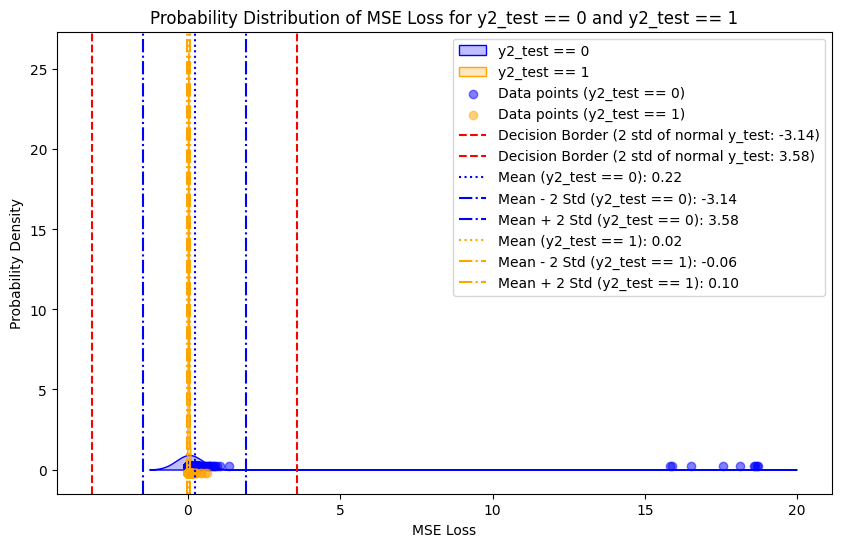

In [ ]:
# Create a KDE for each class
kde_0 = gaussian_kde(mse_loss_datawise[y2_test == 2])
kde_1 = gaussian_kde(mse_loss_datawise[y2_test == 1])

# Create a range of values for the x-axis
x_values = np.linspace(min(mse_loss_datawise), max(mse_loss_datawise), 1000)

# Calculate the KDE values for each class
kde_values_0 = kde_0(x_values)
kde_values_1 = kde_1(x_values)

# Calculate mean and std for both distributions
mean_0, std_0 = np.mean(mse_loss_datawise[y2_test == 2]), np.std(mse_loss_datawise[y2_test == 2])
mean_1, std_1 = np.mean(mse_loss_datawise[y2_test == 1]), np.std(mse_loss_datawise[y2_test == 1])

# Plot the KDEs
plt.figure(figsize=(10, 6))
sns.kdeplot(mse_loss_datawise[y2_test == 2], label='y2_test == 0', fill=True, color='blue')
sns.kdeplot(mse_loss_datawise[y2_test == 1], label='y2_test == 1', fill=True, color='orange')

# Plot individual data points
plt.scatter(mse_loss_datawise[y2_test == 2], np.zeros_like(mse_loss_datawise[y2_test == 2]) + 0.2, color='blue', alpha=0.5, label='Data points (y2_test == 0)')
plt.scatter(mse_loss_datawise[y2_test == 1], np.zeros_like(mse_loss_datawise[y2_test == 1]) - 0.2, color='orange', alpha=0.5, label='Data points (y2_test == 1)')

# Calculate the decision border (2 std of mse_loss for y2_test == 0)
decision_border0 = mean_0 + 2 * std_0
decision_border2 = mean_0 - 2 * std_0

# Plot the decision border
plt.axvline(x=decision_border2, color='red', linestyle='--', label=f'Decision Border (2 std of normal y_test: {decision_border2:.2f})')
plt.axvline(x=decision_border0, color='red', linestyle='--', label=f'Decision Border (2 std of normal y_test: {decision_border0:.2f})')

# Plot mean and std lines for y2_test == 0
plt.axvline(x=mean_0, color='blue', linestyle=':', label=f'Mean (y2_test == 0): {mean_0:.2f}')
plt.axvline(x=mean_0 - std_0, color='blue', linestyle='-.', label=f'Mean - 2 Std (y2_test == 0): {mean_0 - 2*std_0:.2f}')
plt.axvline(x=mean_0 + std_0, color='blue', linestyle='-.', label=f'Mean + 2 Std (y2_test == 0): {mean_0 + 2*std_0:.2f}')

# Plot mean and std lines for y2_test == 1
plt.axvline(x=mean_1, color='orange', linestyle=':', label=f'Mean (y2_test == 1): {mean_1:.2f}')
plt.axvline(x=mean_1 - std_1, color='orange', linestyle='-.', label=f'Mean - 2 Std (y2_test == 1): {mean_1 - 2*std_1:.2f}')
plt.axvline(x=mean_1 + std_1, color='orange', linestyle='-.', label=f'Mean + 2 Std (y2_test == 1): {mean_1 + 2*std_1:.2f}')

# Add labels and legend
plt.xlabel('MSE Loss')
plt.ylabel('Probability Density')
plt.title('Probability Distribution of MSE Loss for y2_test == 0 and y2_test == 1')
plt.legend(loc='upper right')

# Show the plot
plt.show()

In [ ]:
# Visualization of the latent space
'''
!pip install ipympl
%matplotlib widget
from google.colab import output
output.enable_custom_widget_manager()

# Use ipympl backend for better interactivity

#import numpy as np
#import matplotlib.pyplot as plt
#plt.ion()
# Create a 3D plot
xfig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
ax.scatter(reconstructed_test[:,0][y2_test==2], reconstructed_test[:,1][y2_test==2], reconstructed_test[:,2][y2_test==2], c='r', marker='o')
ax.scatter(reconstructed_test[:,0][y2_test==1], reconstructed_test[:,1][y2_test==1], reconstructed_test[:,2][y2_test==1], c='b', marker='o')

# Set labels for the axes
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
# Show the plot
plt.show()
#input("Press Enter to exit...")  # This keeps the plot window open until you press Enter
'''


'\n!pip install ipympl\n%matplotlib widget\nfrom google.colab import output\noutput.enable_custom_widget_manager()\n\n# Use ipympl backend for better interactivity\n\n#import numpy as np\n#import matplotlib.pyplot as plt\n#plt.ion()\n# Create a 3D plot\nxfig = plt.figure()\nax = fig.add_subplot(111, projection=\'3d\')\n\n# Plot the data points\nax.scatter(reconstructed_test[:,0][y2_test==2], reconstructed_test[:,1][y2_test==2], reconstructed_test[:,2][y2_test==2], c=\'r\', marker=\'o\')\nax.scatter(reconstructed_test[:,0][y2_test==1], reconstructed_test[:,1][y2_test==1], reconstructed_test[:,2][y2_test==1], c=\'b\', marker=\'o\')\n\n# Set labels for the axes\nax.set_xlabel(\'X Axis\')\nax.set_ylabel(\'Y Axis\')\nax.set_zlabel(\'Z Axis\')\n# Show the plot\nplt.show()\n#input("Press Enter to exit...")  # This keeps the plot window open until you press Enter\n'

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 12)             │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 24)             │           312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 48)             │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 13)             │           637 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,233 (8.72 KB)

 Trainable params: 2,233 (8.72 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 1.0012 - val_loss: 0.9225
Epoch 2/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9304 - val_loss: 0.9097
Epoch 3/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9172 - val_loss: 0.9051
Epoch 4/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9114 - val_loss: 0.9043
Epoch 5/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9104 - val_loss: 0.9040
Epoch 6/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9094 - val_loss: 0.9039
Epoch 7/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9089 - val_loss: 0.9039
Epoch 8/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9083 - val_loss: 0.9039
Epoch 9/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9094 - val_loss: 0.9035
Epoch 10/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9075 - val_loss: 0.9036
Epoch 11/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9082 - val_loss: 0.9036
Epoch 12/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9081 - val_l

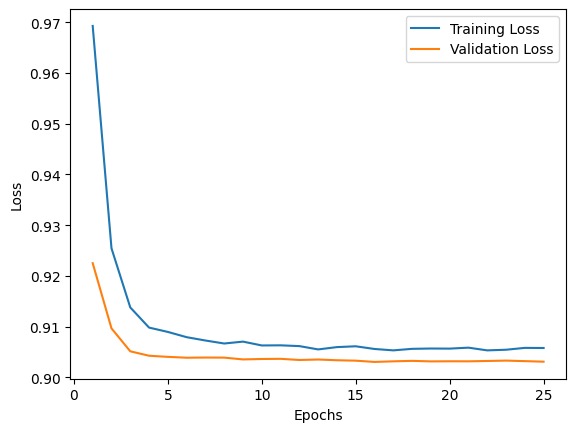

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [ ]:
decoder_ad=train_decoder(X_train[y2==1],reconstructed_train, epochs=25, val_split=0.2)
#reconstructed_X_test_ad = decmodel.predict(reconstructed_test)
reconstructed_X_test_ad = decoder_ad.predict(reconstructed_test)


In [ ]:
'''np.sort(np.mean(reconstructed_X_test_ad-X_test, axis=0)**2)
diffs=reconstructed_X_test_ad-X_test
outliers= np.zeros(diffs.shape[1])
for col in range(diffs.shape[1]):
  outliers[col]=np.sum(np.mean(diffs,axis=1)+1.97*np.std(diffs,axis=1)<=diffs[:,col],axis=0) +np.sum(np.mean(diffs,axis=1)-1.97*np.std(diffs,axis=1)>=diffs[:,col],axis=0)
  print(outliers[col], " outliers in ", attributes[col])
print(np.mean(outliers[[0,1,5,6]]),np.std(outliers[[0,1,5,6]]))
print(0.05*X_test.shape[0])'''

'np.sort(np.mean(reconstructed_X_test_ad-X_test, axis=0)**2)\ndiffs=reconstructed_X_test_ad-X_test\noutliers= np.zeros(diffs.shape[1])\nfor col in range(diffs.shape[1]):\n  outliers[col]=np.sum(np.mean(diffs,axis=1)+1.97*np.std(diffs,axis=1)<=diffs[:,col],axis=0) +np.sum(np.mean(diffs,axis=1)-1.97*np.std(diffs,axis=1)>=diffs[:,col],axis=0)\n  print(outliers[col], " outliers in ", attributes[col])\nprint(np.mean(outliers[[0,1,5,6]]),np.std(outliers[[0,1,5,6]]))\nprint(0.05*X_test.shape[0])'

In [ ]:
#np.mean((reconstructed_X_test_ad-X_test)**2,axis=0)
#np.std((reconstructed_X_test_ad-X_test)**2,axis=0)

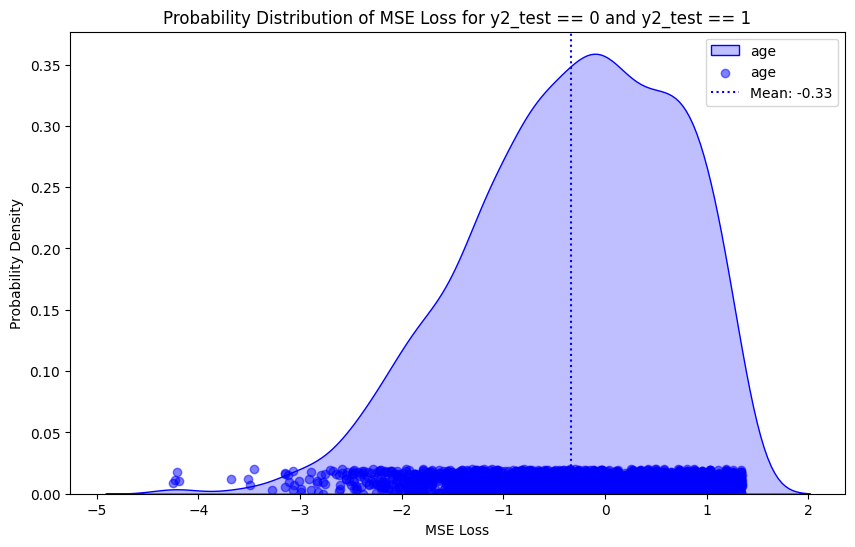

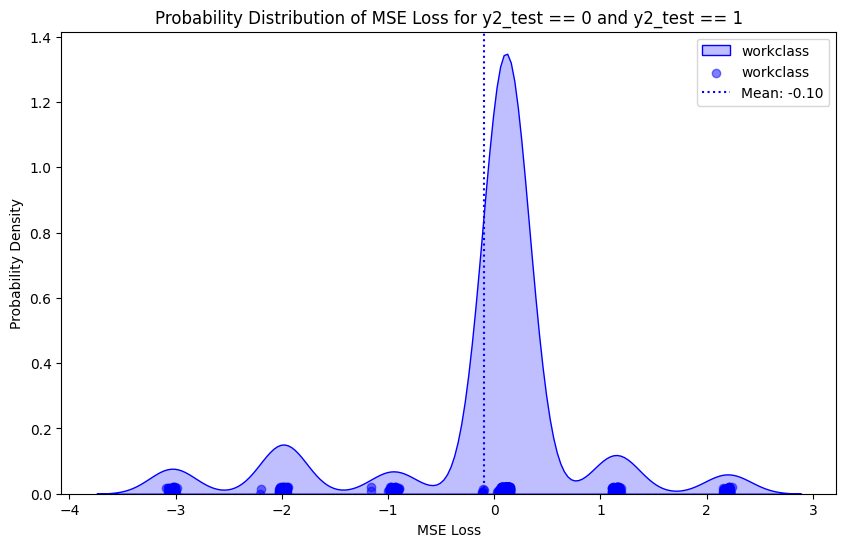

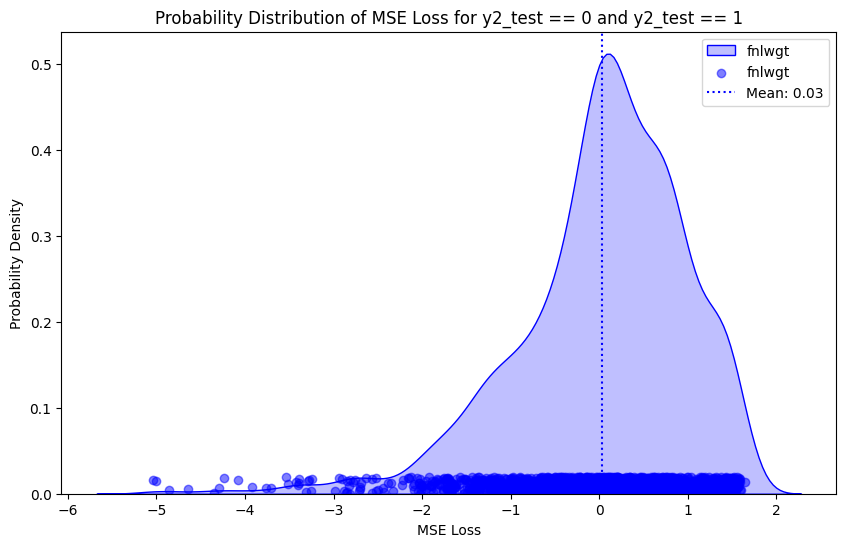

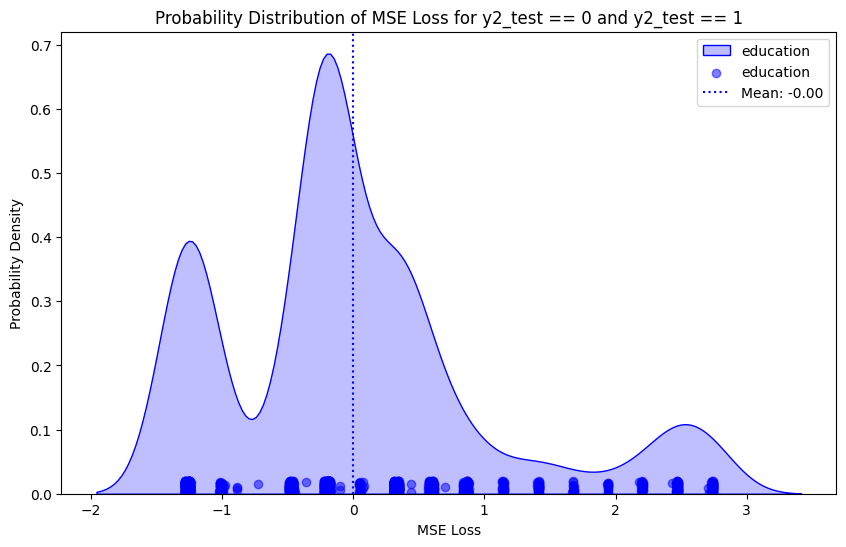

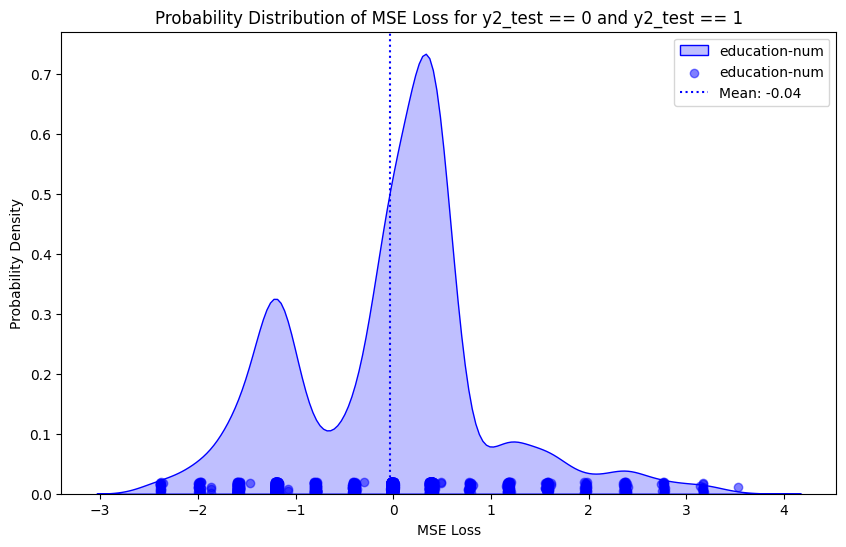

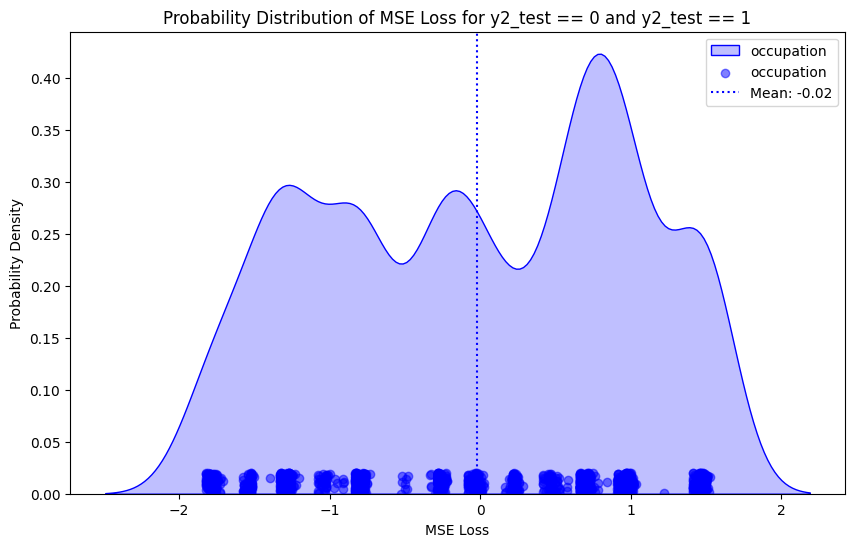

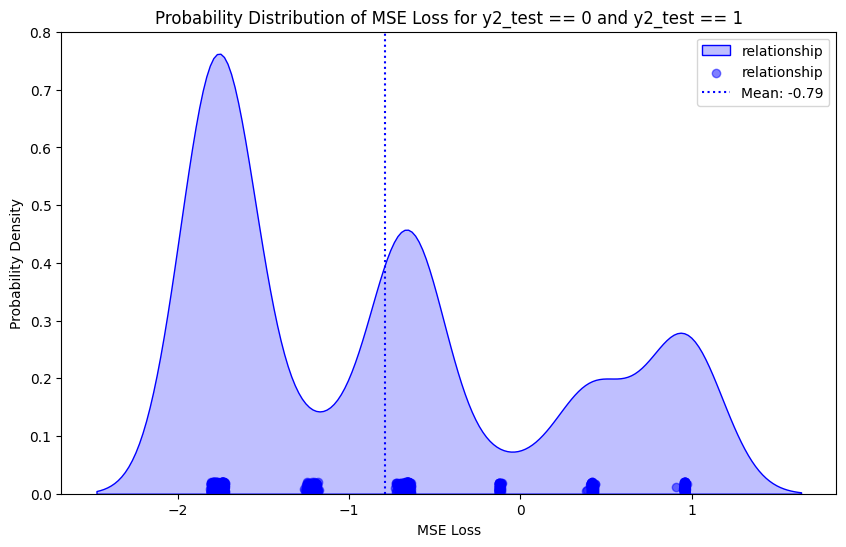

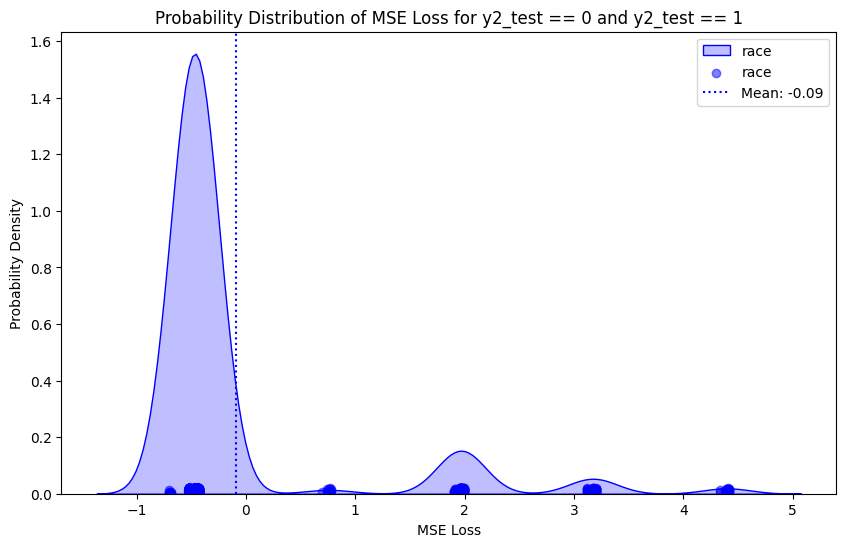

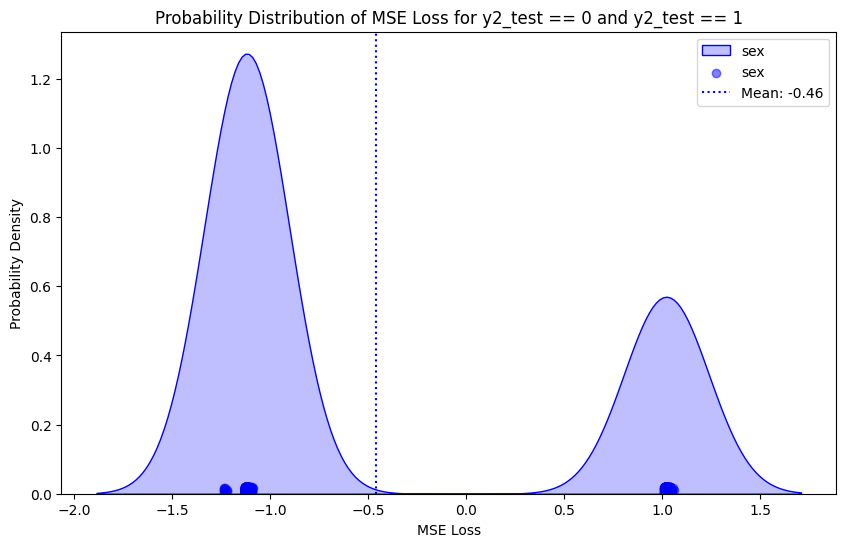

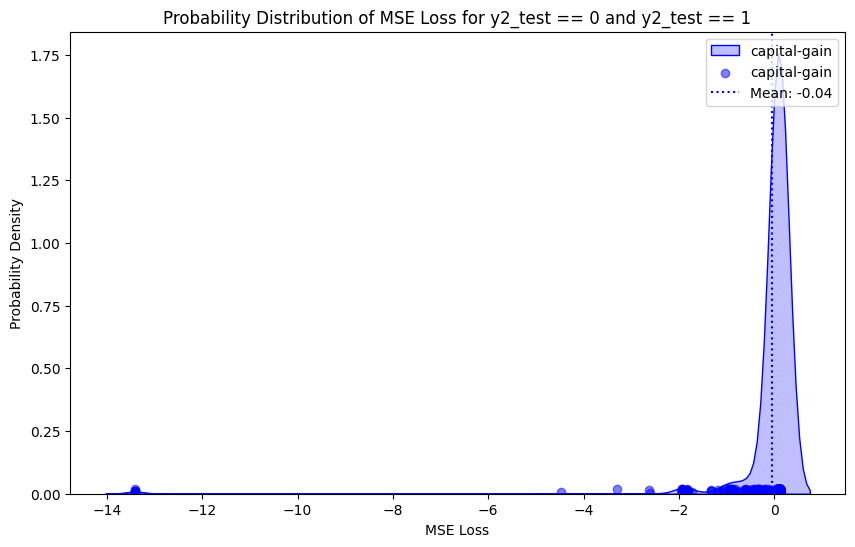

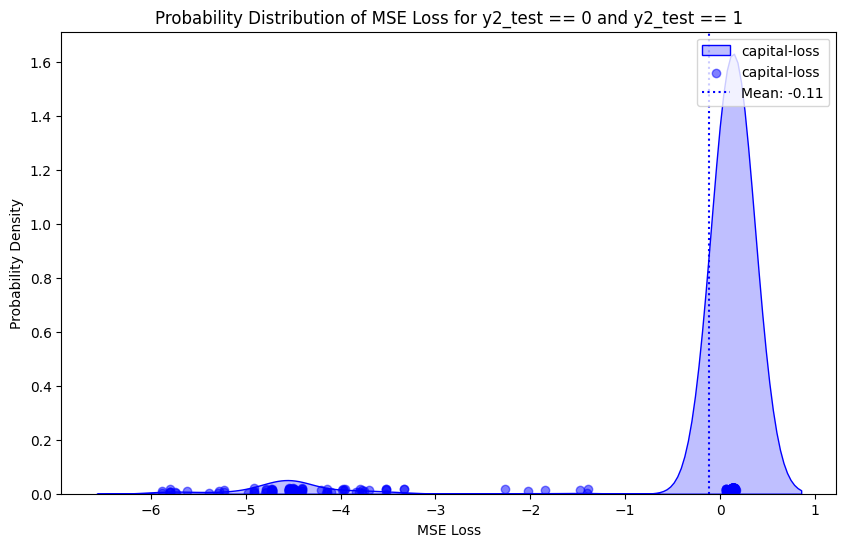

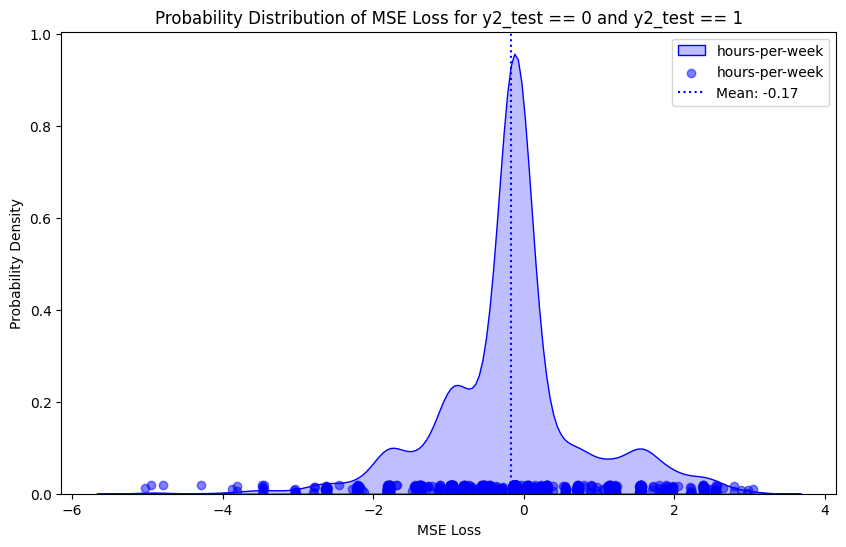

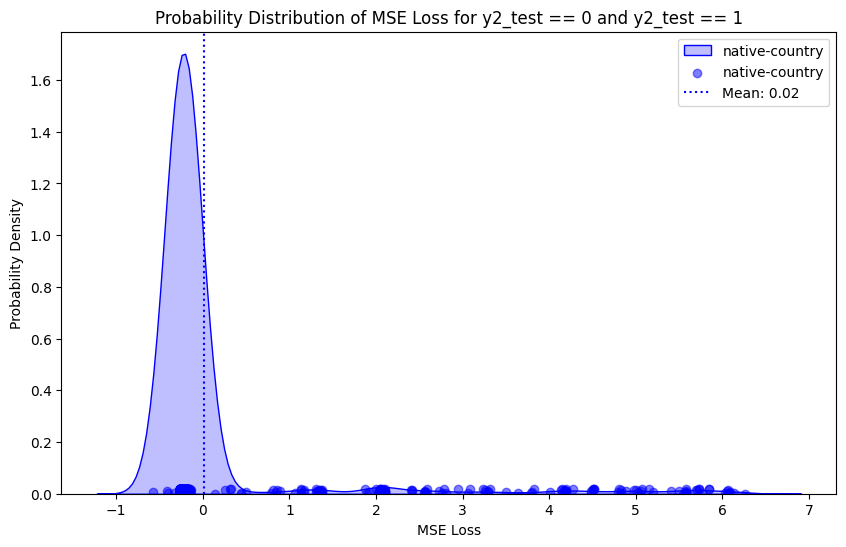

In [ ]:
quad_diffs= (reconstructed_X_test_ad-X_test)
for i in range(X_test.shape[1]):
    # Create a KDE for each class
    kde_0 = gaussian_kde(quad_diffs[:,i])

    # Create a range of values for the x-axis
    x_values = np.linspace(np.min(quad_diffs), np.max(quad_diffs), 1000)

    # Calculate the KDE values for each class
    kde_values_0 = kde_0(x_values)

    # Calculate mean and std for both distributions
    mean_0, std_0 = np.mean(quad_diffs[:,i]), np.std(quad_diffs[:,i])

    # Plot the KDEs
    plt.figure(figsize=(10, 6))
    sns.kdeplot(quad_diffs[:,i], label=attributes[i], fill=True, color='blue')

    # Plot individual data points
    jitter=np.random.random_sample(size=X_test.shape[0])*0.02
    plt.scatter(quad_diffs[:,i], np.zeros_like(quad_diffs[:,i]) + jitter, color='blue', alpha=0.5, label=attributes[i])


    # Plot mean and std lines for y2_test == 0
    plt.axvline(x=mean_0, color='blue', linestyle=':', label=f'Mean: {mean_0:.2f}')

    # Add labels and legend
    plt.xlabel('MSE Loss')
    plt.ylabel('Probability Density')
    plt.title('Probability Distribution of MSE Loss for y2_test == 0 and y2_test == 1')
    plt.legend(loc='upper right')

    # Show the plot
plt.show()

In [ ]:
for x in range(attributes.shape[0]):
  print( f"{attributes[np.argsort(-np.mean(quad_diffs, axis=0))][x]} differs from original by {-np.sort(-np.mean(quad_diffs, axis=0))[x]:.3f}")


fnlwgt differs from original by 0.032
native-country differs from original by 0.018
education differs from original by -0.001
occupation differs from original by -0.018
education-num differs from original by -0.035
capital-gain differs from original by -0.038
race differs from original by -0.094
workclass differs from original by -0.101
capital-loss differs from original by -0.114
hours-per-week differs from original by -0.173
age differs from original by -0.332
sex differs from original by -0.457
relationship differs from original by -0.794


# AD baseline

In [ ]:
# Initialize model, loss, optimizer
autoencoder = Autoencoder(input_dim, latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate)
loss_fn = tf.keras.losses.MeanSquaredError()

In [ ]:
# Training Loop
x_train = encoded_X_train
x_test = encoded_X_test
epochs = 20
batch_size = 256
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Shuffle training data for each epoch
    idx = np.random.permutation(len(x_train))
    x_train = encoded_X_train[idx]

    # Iterate through batches
    for i in range(0, len(x_train), batch_size):
        batch = x_train[i:i + batch_size]
        batch = tf.convert_to_tensor(batch, dtype=tf.float32)

        # Run a training step
        proje_loss, opc_loss, total_loss = train_step(X_train,x_train,decmodel)

        # Print progress
        #if ((i) % int(len(x_train)/20)) == 0:
    print(f"Projection loss: {proj_loss.numpy():.3f}, OPC_loss: {opc_loss.numpy():.4f}, Total Loss = {total_loss.numpy():.4f}")
'''
for epoch in range(epochs):
    loss = train_step(encoded_X_train)
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{epochs}], Loss: {loss.numpy():.4f}")
'''






Epoch 1/20
Projection loss: 0.128, OPC_loss: 2.5196, Total Loss = 2.2242
Epoch 2/20
Projection loss: 0.128, OPC_loss: 1.2223, Total Loss = 1.6465
Epoch 3/20
Projection loss: 0.128, OPC_loss: 0.3626, Total Loss = 1.2754
Epoch 4/20
Projection loss: 0.128, OPC_loss: 0.0184, Total Loss = 1.1325
Epoch 5/20
Projection loss: 0.128, OPC_loss: 0.0169, Total Loss = 1.1300
Epoch 6/20
Projection loss: 0.128, OPC_loss: 0.0160, Total Loss = 1.1262
Epoch 7/20
Projection loss: 0.128, OPC_loss: 0.0164, Total Loss = 1.1250
Epoch 8/20
Projection loss: 0.128, OPC_loss: 0.0153, Total Loss = 1.1226
Epoch 9/20
Projection loss: 0.128, OPC_loss: 0.0151, Total Loss = 1.1237
Epoch 10/20
Projection loss: 0.128, OPC_loss: 0.0147, Total Loss = 1.1225
Epoch 11/20
Projection loss: 0.128, OPC_loss: 0.0146, Total Loss = 1.1236
Epoch 12/20
Projection loss: 0.128, OPC_loss: 0.0132, Total Loss = 1.1202
Epoch 13/20
Projection loss: 0.128, OPC_loss: 0.0144, Total Loss = 1.1220
Epoch 14/20
Projection loss: 0.128, OPC_loss: 0

'\nfor epoch in range(epochs):\n    loss = train_step(encoded_X_train)\n    if epoch % 10 == 0:\n        print(f"Epoch [{epoch}/{epochs}], Loss: {loss.numpy():.4f}")\n'

In [ ]:
# After training, you can evaluate the model or detect anomalies similarly as before
reconstructed_test_base, Z = autoencoder.predict(x_test)
reconstructed_train_base, Z = autoencoder.predict(x_train)
#print(reconstructed)
#print(x_test.shape)
mse_loss_datawise_base = np.mean(np.square(x_test - reconstructed_test), axis=1)
mse_loss_featurewise_base = np.mean(np.square(x_test - reconstructed_test), axis=0)

# Detect anomalies based on a threshold
threshold_base = np.percentile(mse_loss_datawise_base, 95)  # Example: top 5% of MSE values as anomalies
anomalies_base = mse_loss_datawise_base > threshold_base


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [ ]:
print("Anomalies detected:", (mse_loss_datawise >( np.mean(mse_loss_datawise)+2*np.std(mse_loss_datawise))).sum())
print(x_test.shape)

print(np.mean(mse_loss_datawise_base),np.var(mse_loss_datawise_base))
print(np.mean(mse_loss_datawise_base),np.var(mse_loss_datawise_base))
print(mse_loss_featurewise)

Anomalies detected: 9
(2000, 6)
0.117184676 1.3973596
0.117184676 1.3973596
[0.1294939  0.01849817 0.15540977 0.07991295 0.03494953 0.28484353]


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 12)             │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 24)             │           312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 48)             │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 13)             │           637 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,233 (8.72 KB)

 Trainable params: 2,233 (8.72 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.0927 - val_loss: 0.9986
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0176 - val_loss: 0.9972
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0127 - val_loss: 0.9976
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0116 - val_loss: 0.9974
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0104 - val_loss: 0.9976
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0095 - val_loss: 0.9978
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0095 - val_loss: 0.9976
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0094 - val_loss: 0.9975
Epoch 9/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0091 - val_loss: 0.9977
Epoch 10/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0094 - val_loss: 0.9977
Epoch 11/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0092 - val_loss: 0.9976
Epoch 12/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

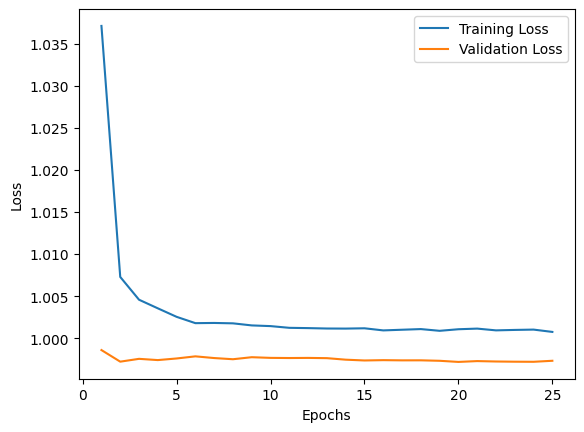

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
decoder_ad_base=train_decoder(X_train,reconstructed_train_base, epochs=25)
reconstructed_X_test_ad_base = decmodel.predict(x_test)
reconstructed_X_test_ad_base2 = decoder_ad_base.predict(reconstructed_test_base)


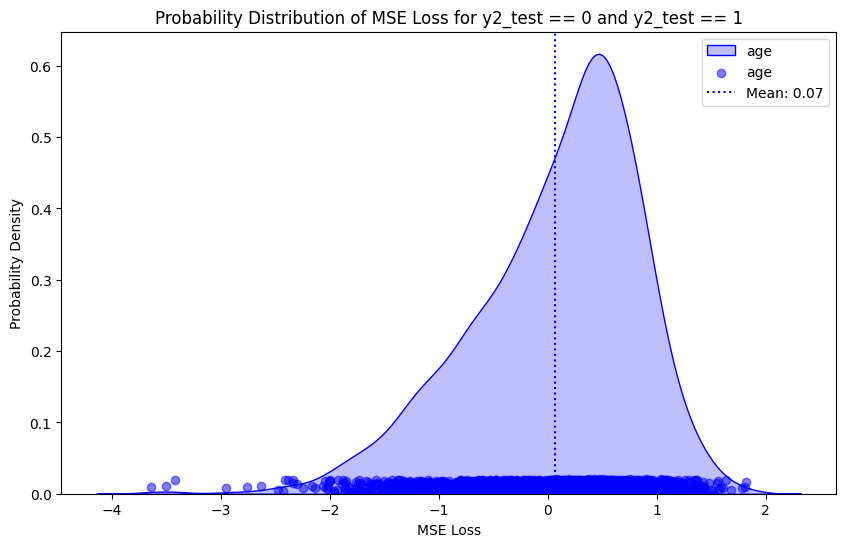

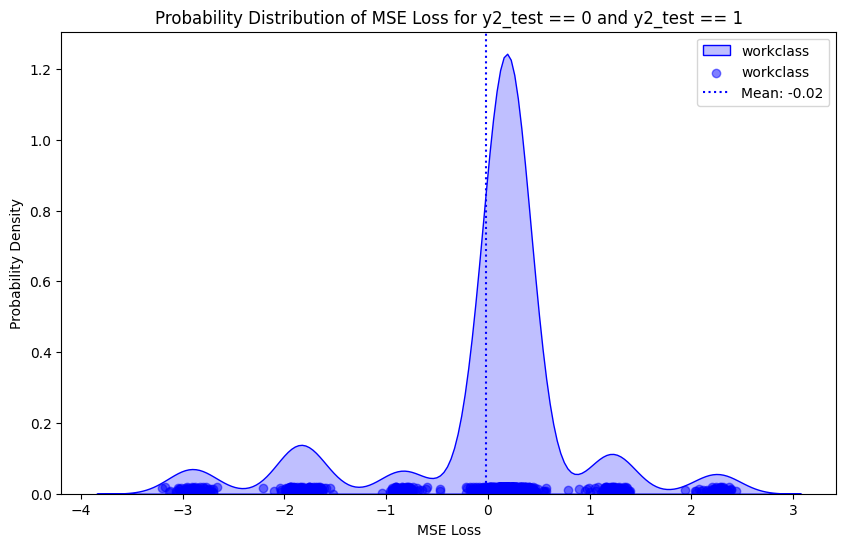

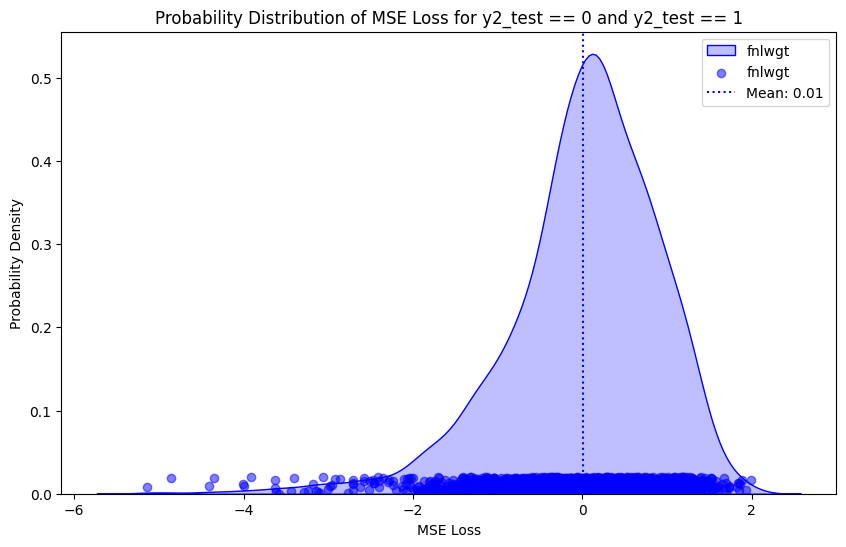

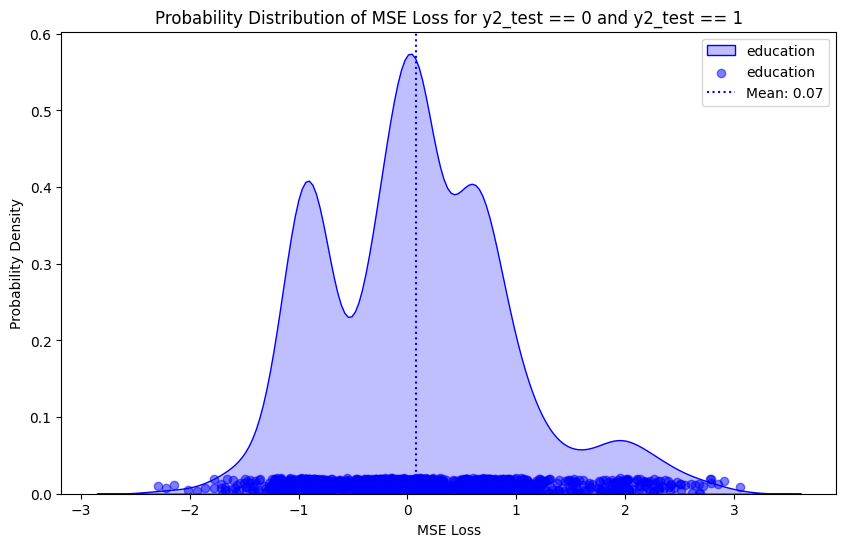

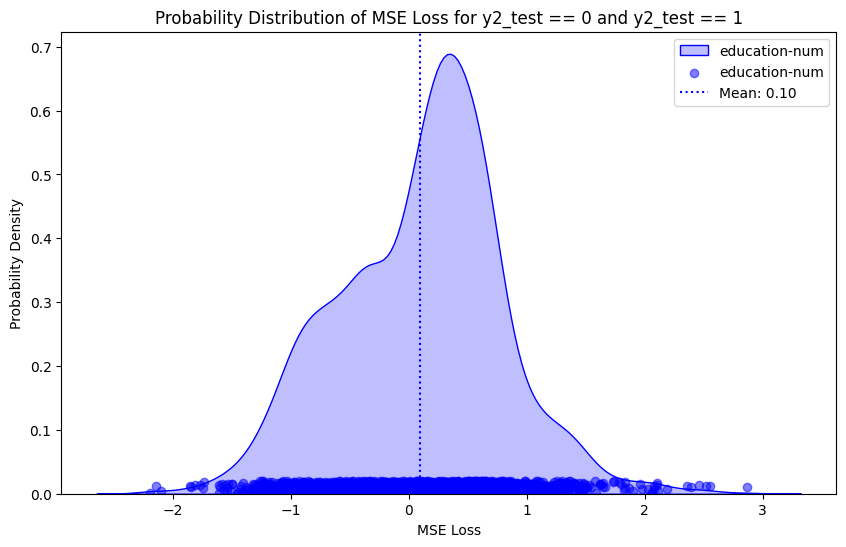

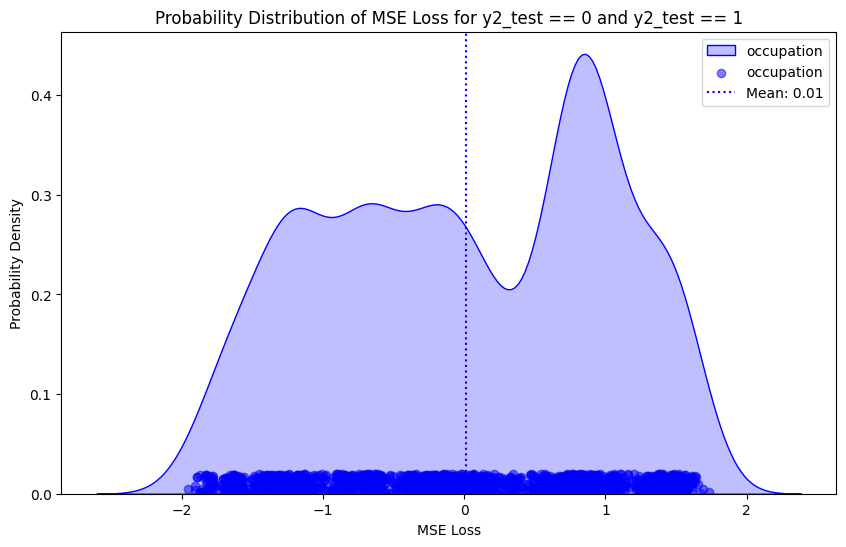

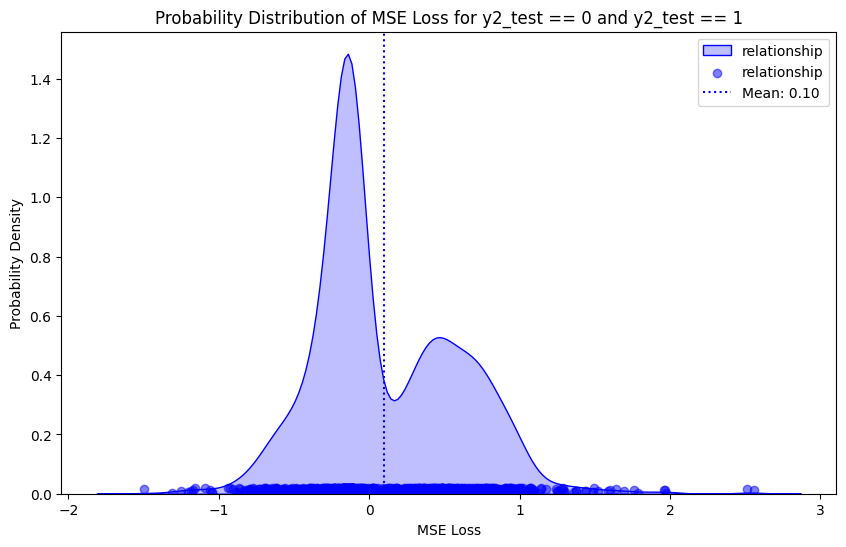

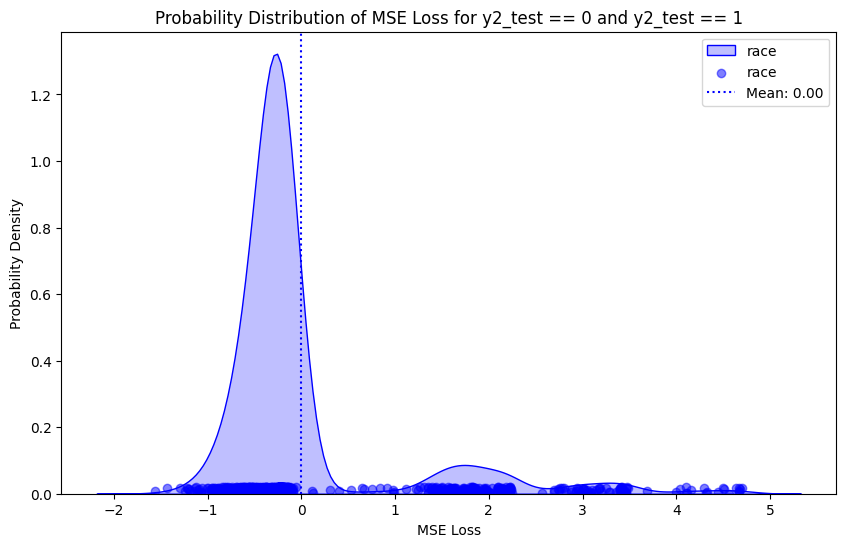

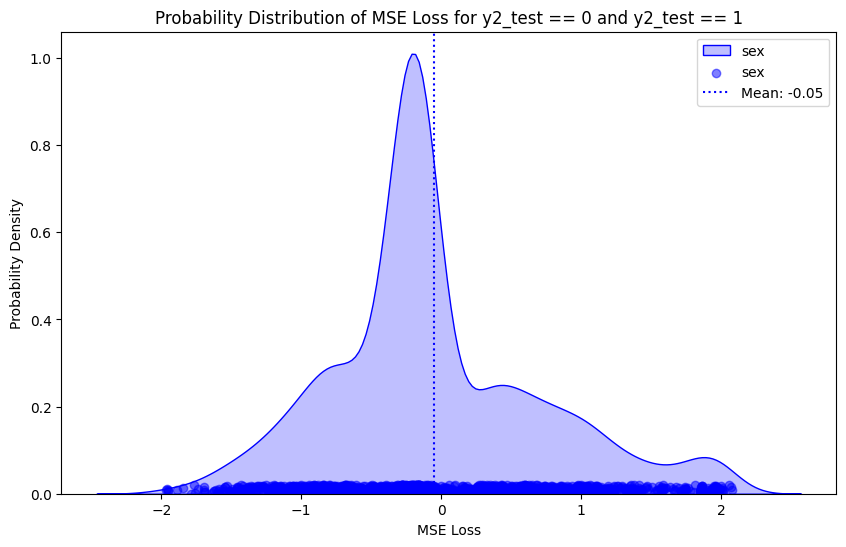

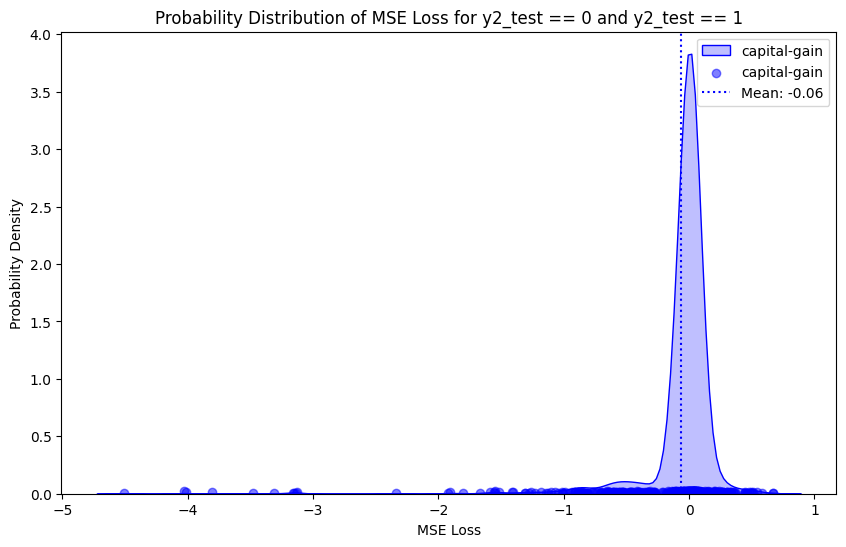

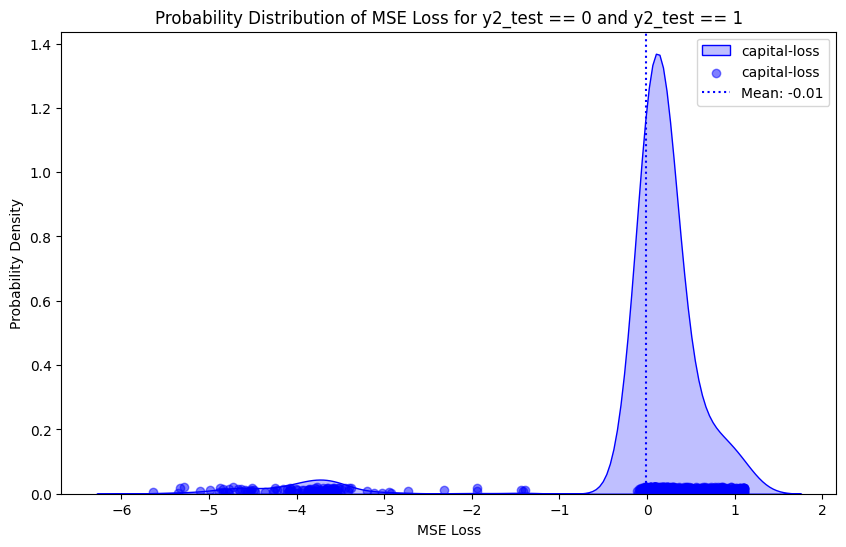

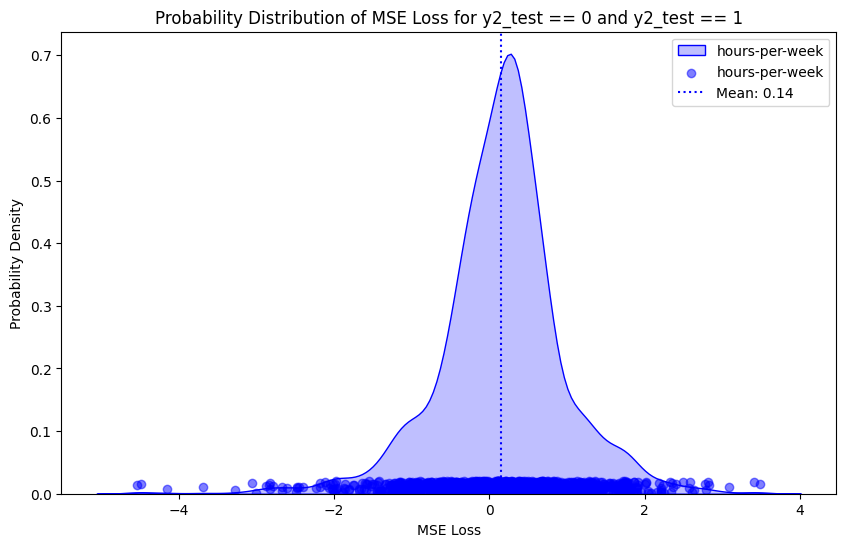

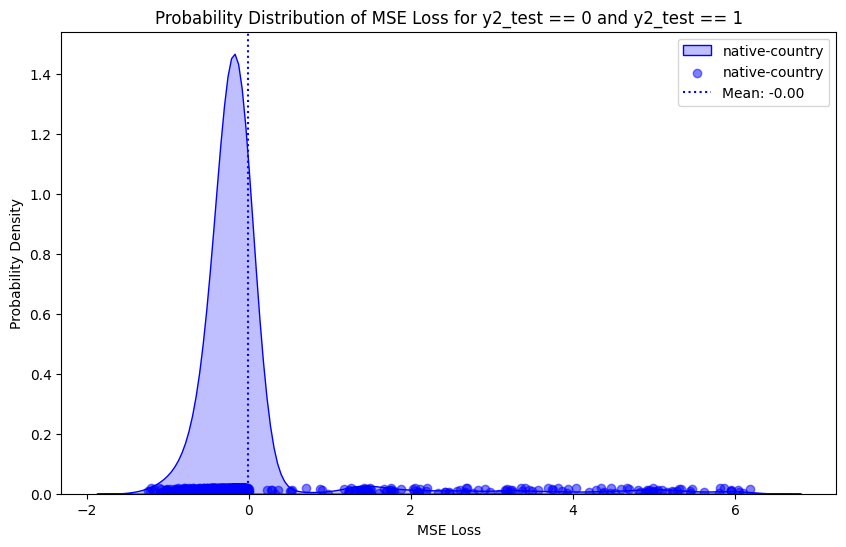

In [ ]:
quad_diffs_base=reconstructed_X_test_ad_base-X_test
for i in range(X_test.shape[1]):
    # Create a KDE for each class
    kde_0 = gaussian_kde(quad_diffs_base[:,i])

    # Create a range of values for the x-axis
    x_values = np.linspace(np.min(quad_diffs_base), np.max(quad_diffs_base), 1000)

    # Calculate the KDE values for each class
    kde_values_0 = kde_0(x_values)

    # Calculate mean and std for both distributions
    mean_0, std_0 = np.mean(quad_diffs_base[:,i]), np.std(quad_diffs_base[:,i])

    # Plot the KDEs
    plt.figure(figsize=(10, 6))
    sns.kdeplot(quad_diffs_base[:,i], label=attributes[i], fill=True, color='blue')

    # Plot individual data points
    jitter=np.random.random_sample(size=X_test.shape[0])*0.02
    plt.scatter(quad_diffs_base[:,i], np.zeros_like(quad_diffs_base[:,i]) + jitter, color='blue', alpha=0.5, label=attributes[i])

    # Plot mean and std lines for y2_test == 0
    plt.axvline(x=mean_0, color='blue', linestyle=':', label=f'Mean: {mean_0:.2f}')

    # Add labels and legend
    plt.xlabel('MSE Loss')
    plt.ylabel('Probability Density')
    plt.title('Probability Distribution of MSE Loss for y2_test == 0 and y2_test == 1')
    plt.legend(loc='upper right')

    # Show the plot
plt.show()

In [ ]:
quad_diffs_base.shape

(2000, 13)

In [ ]:
for x in range(attributes.shape[0]):
  print( f"{attributes[np.argsort(-np.mean(quad_diffs_base, axis=0))][x]} differs from original by {-np.sort(-np.mean(quad_diffs_base, axis=0))[x]:.3f}")



hours-per-week differs from original by 0.145
relationship differs from original by 0.100
education-num differs from original by 0.100
education differs from original by 0.075
age differs from original by 0.067
occupation differs from original by 0.011
fnlwgt differs from original by 0.006
race differs from original by 0.002
native-country differs from original by -0.004
capital-loss differs from original by -0.011
workclass differs from original by -0.017
sex differs from original by -0.048
capital-gain differs from original by -0.061


#Comparison baseline vs sensitive AD

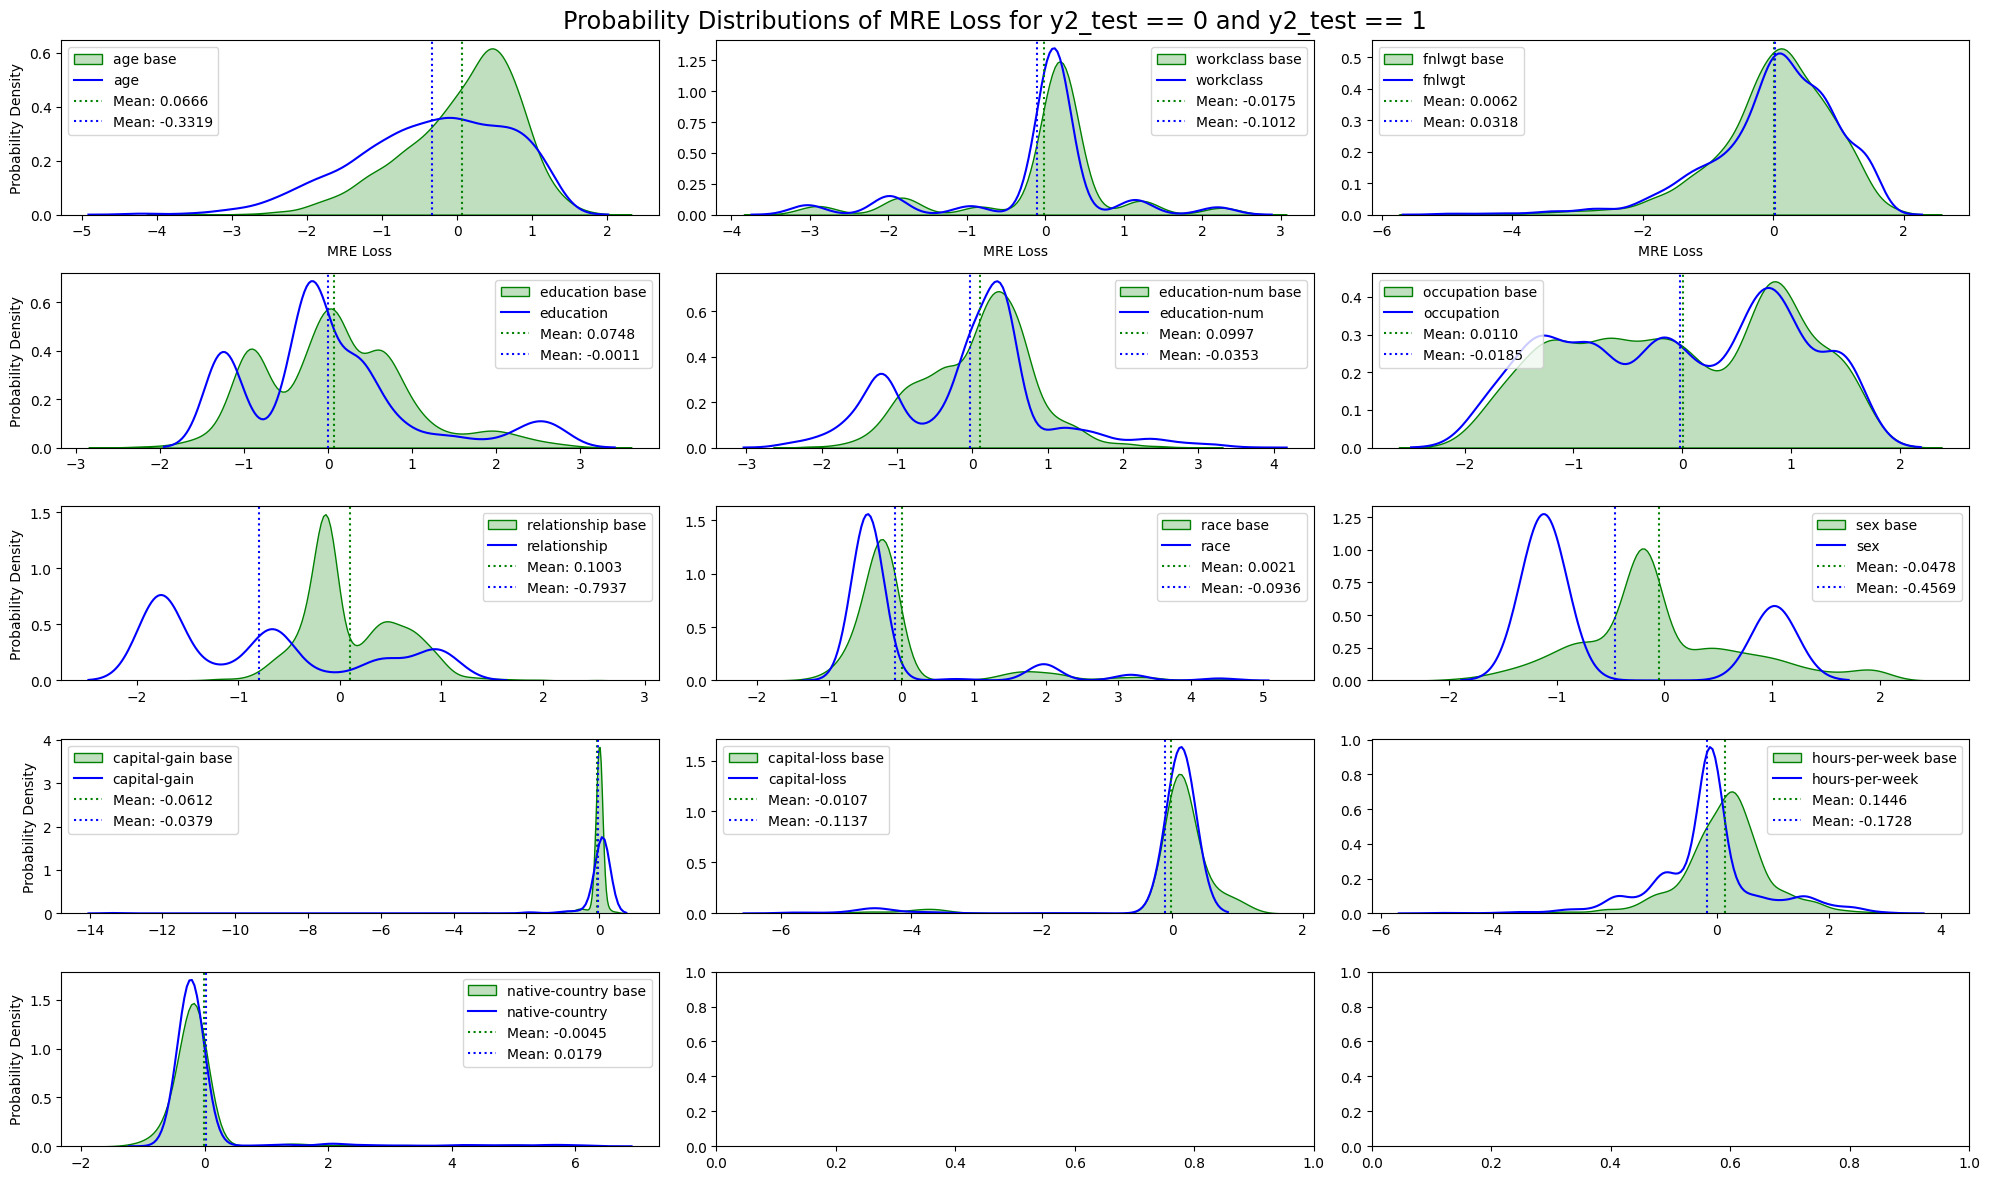

In [ ]:
quad_diffs=quad_diffs
quad_diffs_base=quad_diffs_base
t=3
fig, ax = plt.subplots(len(attributes)//t+1,t, figsize=(20,12))
for i in range(X_test.shape[1]):
    # Create a KDE for each class
    kde_0 = gaussian_kde(quad_diffs_base[:,i])
    kde_2 = gaussian_kde(quad_diffs[:,i])
    # Create a range of values for the x-axis
    x_values = np.linspace(np.min((quad_diffs,quad_diffs_base)), np.max((quad_diffs,quad_diffs_base)), 1000)

    # Calculate the KDE values for each class
    kde_values_0 = kde_0(x_values)
    kde_values_2 = kde_2(x_values)

    # Calculate mean and std for both distributions
    mean_0, std_0 = np.mean(quad_diffs_base[:,i]), np.std(quad_diffs_base[:,i])
    mean_2, std_2 = np.mean(quad_diffs[:,i]), np.std(quad_diffs[:,i])

    # Plot the KDEs
    sns.kdeplot(quad_diffs_base[:,i], label=f"{attributes[i]} base", ax=ax[i//t,i%t], fill=True, color='green')
    sns.kdeplot(quad_diffs[:,i], label=attributes[i], ax=ax[i//t,i%t], fill=False, color='blue')

    # Plot individual data points
    jitter=np.random.random_sample(size=X_test.shape[0])*0.03
    jitter2=np.random.random_sample(size=X_test.shape[0])*0.03
    #ax[i//t,i%t].scatter(quad_diffs_base[:,i], np.zeros_like(quad_diffs_base[:,i]) + jitter, color='green', alpha=0.7, label=f"{attributes[i]} base")
    #ax[i//t,i%t].scatter(quad_diffs[:,i], np.zeros_like(quad_diffs[:,i]) + jitter2, color='blue', alpha=0.5, label=attributes[i])

    # Plot mean and std lines for y2_test == 0
    ax[i//t,i%t].axvline(x=mean_0, color='green', linestyle=':', label=f'Mean: {mean_0:.4f}')
    ax[i//t,i%t].axvline(x=mean_2, color='blue', linestyle=':', label=f'Mean: {mean_2:.4f}')

    # Add labels and legend
    #ax[i//t,i%t].set_xlabel('MSE Loss')
    #ax[i//t,i%t].set_ylabel('Probability Density')
    if i%t==0:
      ax[i//t,i%t].set_ylabel('Probability Density')
    else:
      ax[i//t,i%t].set_ylabel('')
    if i//t==0:
      ax[i//t,i%t].set_xlabel('MRE Loss')
    ax[i//t,i%t].legend()

# Show the plot
fig.suptitle('Probability Distributions of MRE Loss for y2_test == 0 and y2_test == 1',fontsize='xx-large')
fig.tight_layout()
plt.savefig(f'ad_comparison_{name}')
plt.show()

In [ ]:
for x in range(attributes.shape[0]):
  print(f"{attributes[np.argsort(-np.mean(quad_diffs-quad_diffs_base,axis=0))][x]} reconstruction difference is on average: {-np.sort(-np.mean(quad_diffs-quad_diffs_base, axis=0))[x]:.3f}")



fnlwgt reconstruction difference is on average: 0.026
capital-gain reconstruction difference is on average: 0.023
native-country reconstruction difference is on average: 0.022
occupation reconstruction difference is on average: -0.029
education reconstruction difference is on average: -0.076
workclass reconstruction difference is on average: -0.084
race reconstruction difference is on average: -0.096
capital-loss reconstruction difference is on average: -0.103
education-num reconstruction difference is on average: -0.135
hours-per-week reconstruction difference is on average: -0.317
age reconstruction difference is on average: -0.398
sex reconstruction difference is on average: -0.409
relationship reconstruction difference is on average: -0.894
